# Importations

In [75]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import functions
from functions import *
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import shap
import random

# Données

## Target

In [4]:
data_set = application_train_test(num_rows = None, nan_as_category = False)

In [25]:
df_bar = pd.DataFrame()
df = data_set[data_set['TARGET'].notna()]
df_bar['TARGET'] = df['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df[df['TARGET']==x]))
df_bar

TARGET   count
0     1.0   24825
1     0.0  282682

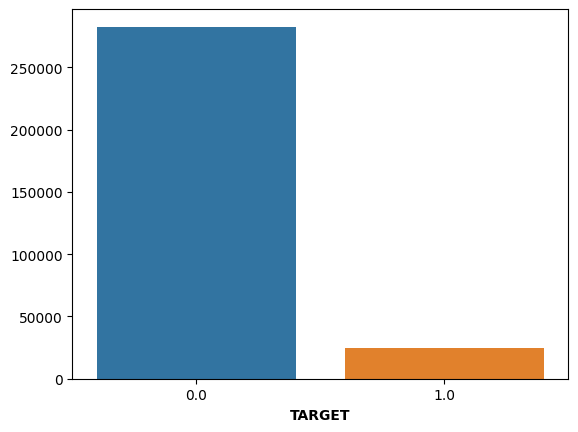

In [26]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [27]:
len(df.loc[df['TARGET']==1])/len(df)*100

8.07298695639449

In [7]:
float_columns = [col for col in df.columns if df[col].dtype == 'float']
int_column = [col for col in df.columns if df[col].dtype == 'int']

## Split train/test and missing datas

In [100]:
def split_and_miss(df):
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    imp = SimpleImputer(strategy='median')
    imp.fit(X_train)
    X_train_full = imp.transform(X_train)
    X_test_full = imp.transform(X_test)
    feats1 = feats.remove('TARGET')
    X_train_full = pd.DataFrame(columns=feats, data=X_train_full)
    X_test_full = pd.DataFrame(columns=feats, data=X_test_full)
    y_train = y_train.reset_index().drop('index', axis=1)
    y_test = y_test.reset_index().drop('index', axis=1)
    
    return X_train_full, X_test_full, y_train, y_test

## Imbalanced data

In [28]:
# Illustration graphique de smote et RandomUnderSampler

In [44]:
df_10000 = phase1()

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 1s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (20000, 779)
data final shape : (20000, 257)


In [45]:
df_bar = pd.DataFrame()
df1 = df_10000[df['TARGET'].notna()]
df_bar['TARGET'] = df1['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df1[df1['TARGET']==x]))
df_bar

TARGET  count
0     1.0    775
1     0.0   9225

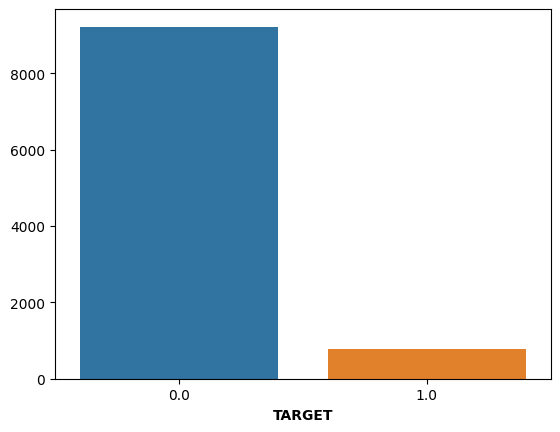

In [46]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [47]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)

In [48]:
feats = [f for f in df1.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index', 'TARGET']]
X_train = df1[feats]
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train_full = imp.transform(X_train)
X_train_full = pd.DataFrame(columns=feats, data=X_train_full)

In [49]:
X_train_over, y_train_over = over.fit_resample(X_train_full, df1['TARGET'])
X_train_under, y_train_under = under.fit_resample(X_train_over, y_train_over)
x_over = ((y_train_over).value_counts()).to_frame()
x_under = (y_train_under.value_counts()).to_frame()

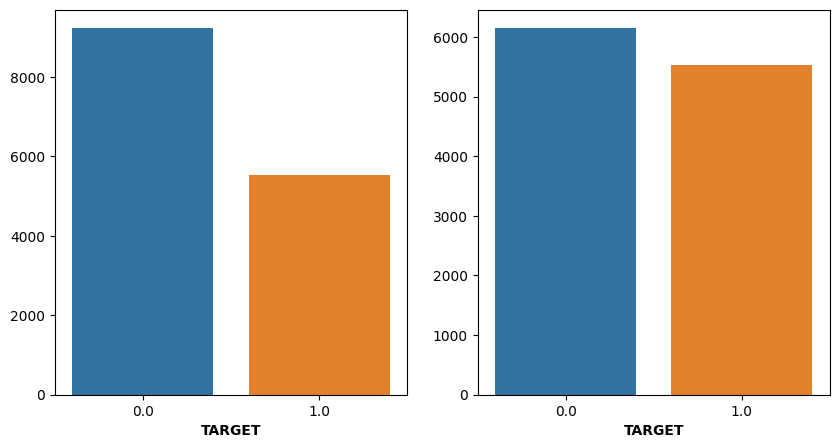

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(ax=ax[0], data=x_over, x=x_over.index, y='TARGET')
sns.barplot(ax=ax[1], data=x_under, x=x_under.index, y='TARGET')
ax[0].set_xlabel('TARGET', weight='bold')
ax[0].set_ylabel('')
ax[1].set_xlabel('TARGET', weight='bold')
ax[1].set_ylabel('');

# Base line : Logistic regression

## Functions
### display_importances

In [41]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    best_features = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values('importance', ascending=False), color='blue', saturation=0.2)
    plt.title('Features Importance(avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

### score_function

In [42]:
def score_function(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return len(y)/(10*cm[1][0] + cm[0][1])
from sklearn.metrics import make_scorer
custom_score = make_scorer(score_function, greater_is_better=True, needs_proba=False)

### score_df

In [43]:
def score_df(results_train, results_valid, results_test):
    df = pd.DataFrame(columns = ['Validation', 'Train', 'Test'], index = ['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    df['Train'] = results_train
    df['Validation'] = results_valid
    df['Test'] = results_test
    return(df)

## roc_auc - Threshold decision function moved

In [80]:
import pickle

def Log_reg(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame(index=['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01) 
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.01, 0.2, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = result_validation_set.mean(axis=1)
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01) 
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'saved_Log_reg_model.joblib'
    joblib.dump(pipe, filename)

    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df)
  


In [81]:
def model1_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression"):
        Log_reg(df, num_folds=10, stratified = True)

Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.11
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.12
Threshold optimum - Mean: 0.1
           Validation      Train       Test
Accuracy     0.886250   0.798625   0.789000
Cost        56.375000  54.112500  56.200000
F1_score     0.325926   0.283044   0.267361
Precision    0.301370   0.195452   0.182898
Profit      35.875000  38.137500  36.050000
Recall       0.354839   0.512903   0.496774
roc_auc      0.657072   0.742171   0.750779
Run Logistic regression - done in 5s


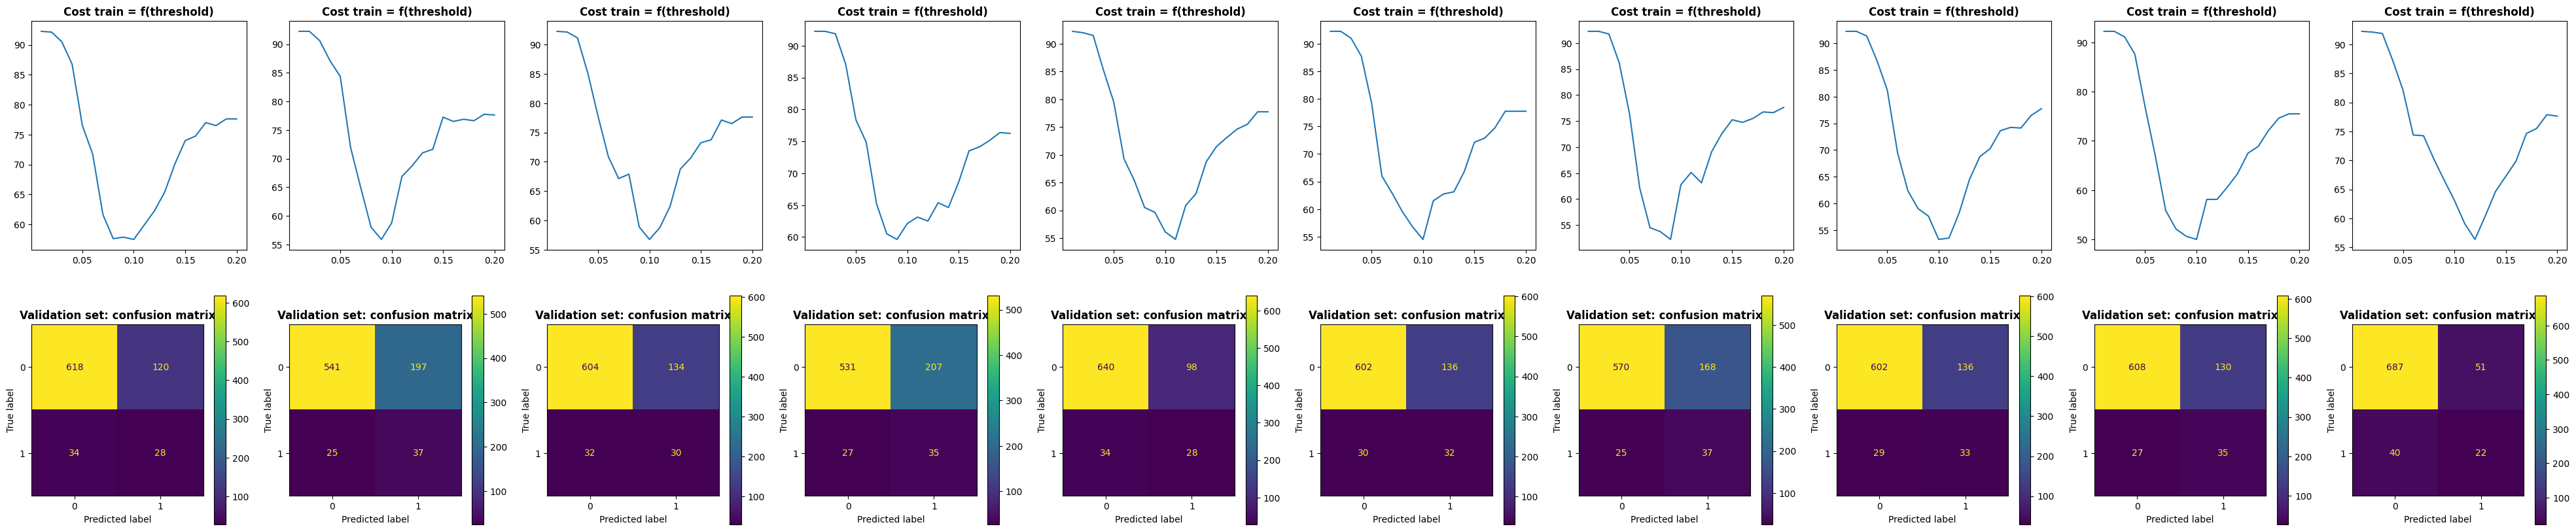

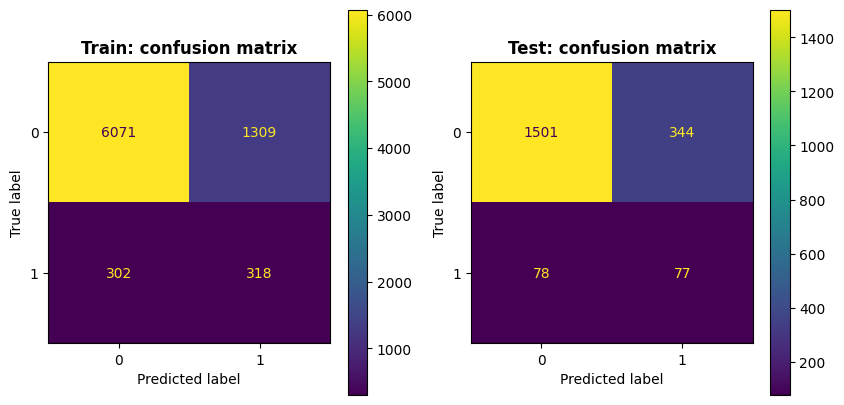

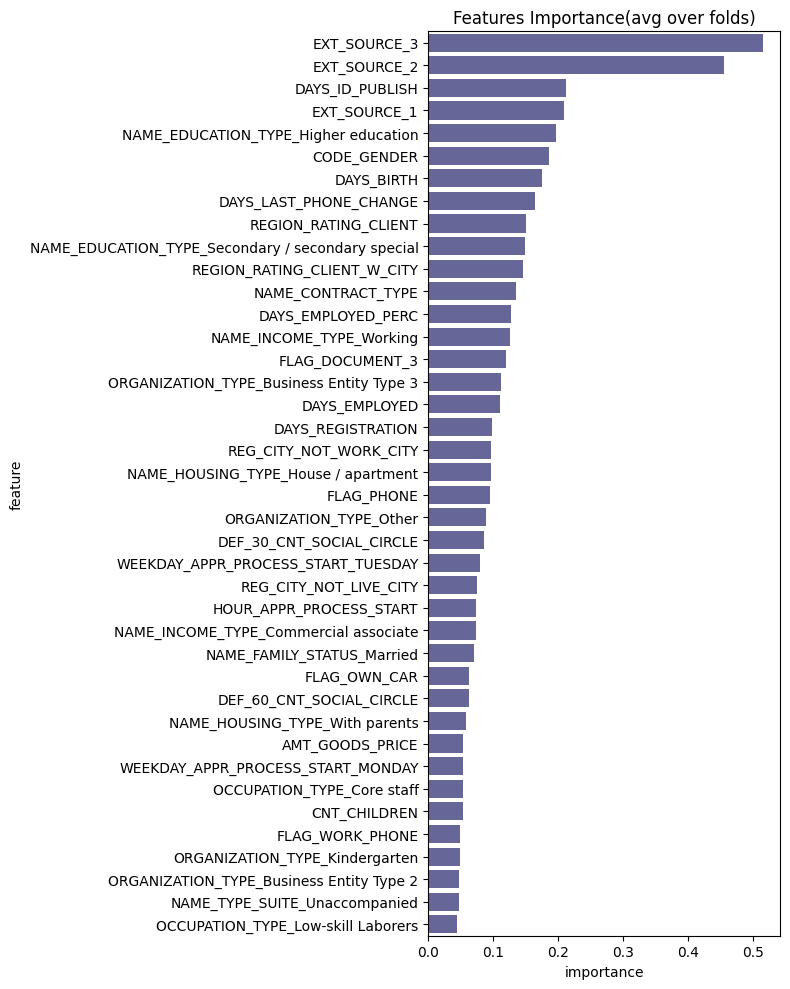

In [82]:
model1_Log_reg(df_10000)

In [87]:
saved_Log_reg_model = joblib.load('saved_Log_reg_model.joblib')

In [101]:
X_train, X_test, y_train, y_test = split_and_miss(df)

In [121]:
y_train.squeeze()

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7995    0.0
7996    0.0
7997    0.0
7998    1.0
7999    0.0
Name: TARGET, Length: 8000, dtype: float64

In [89]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

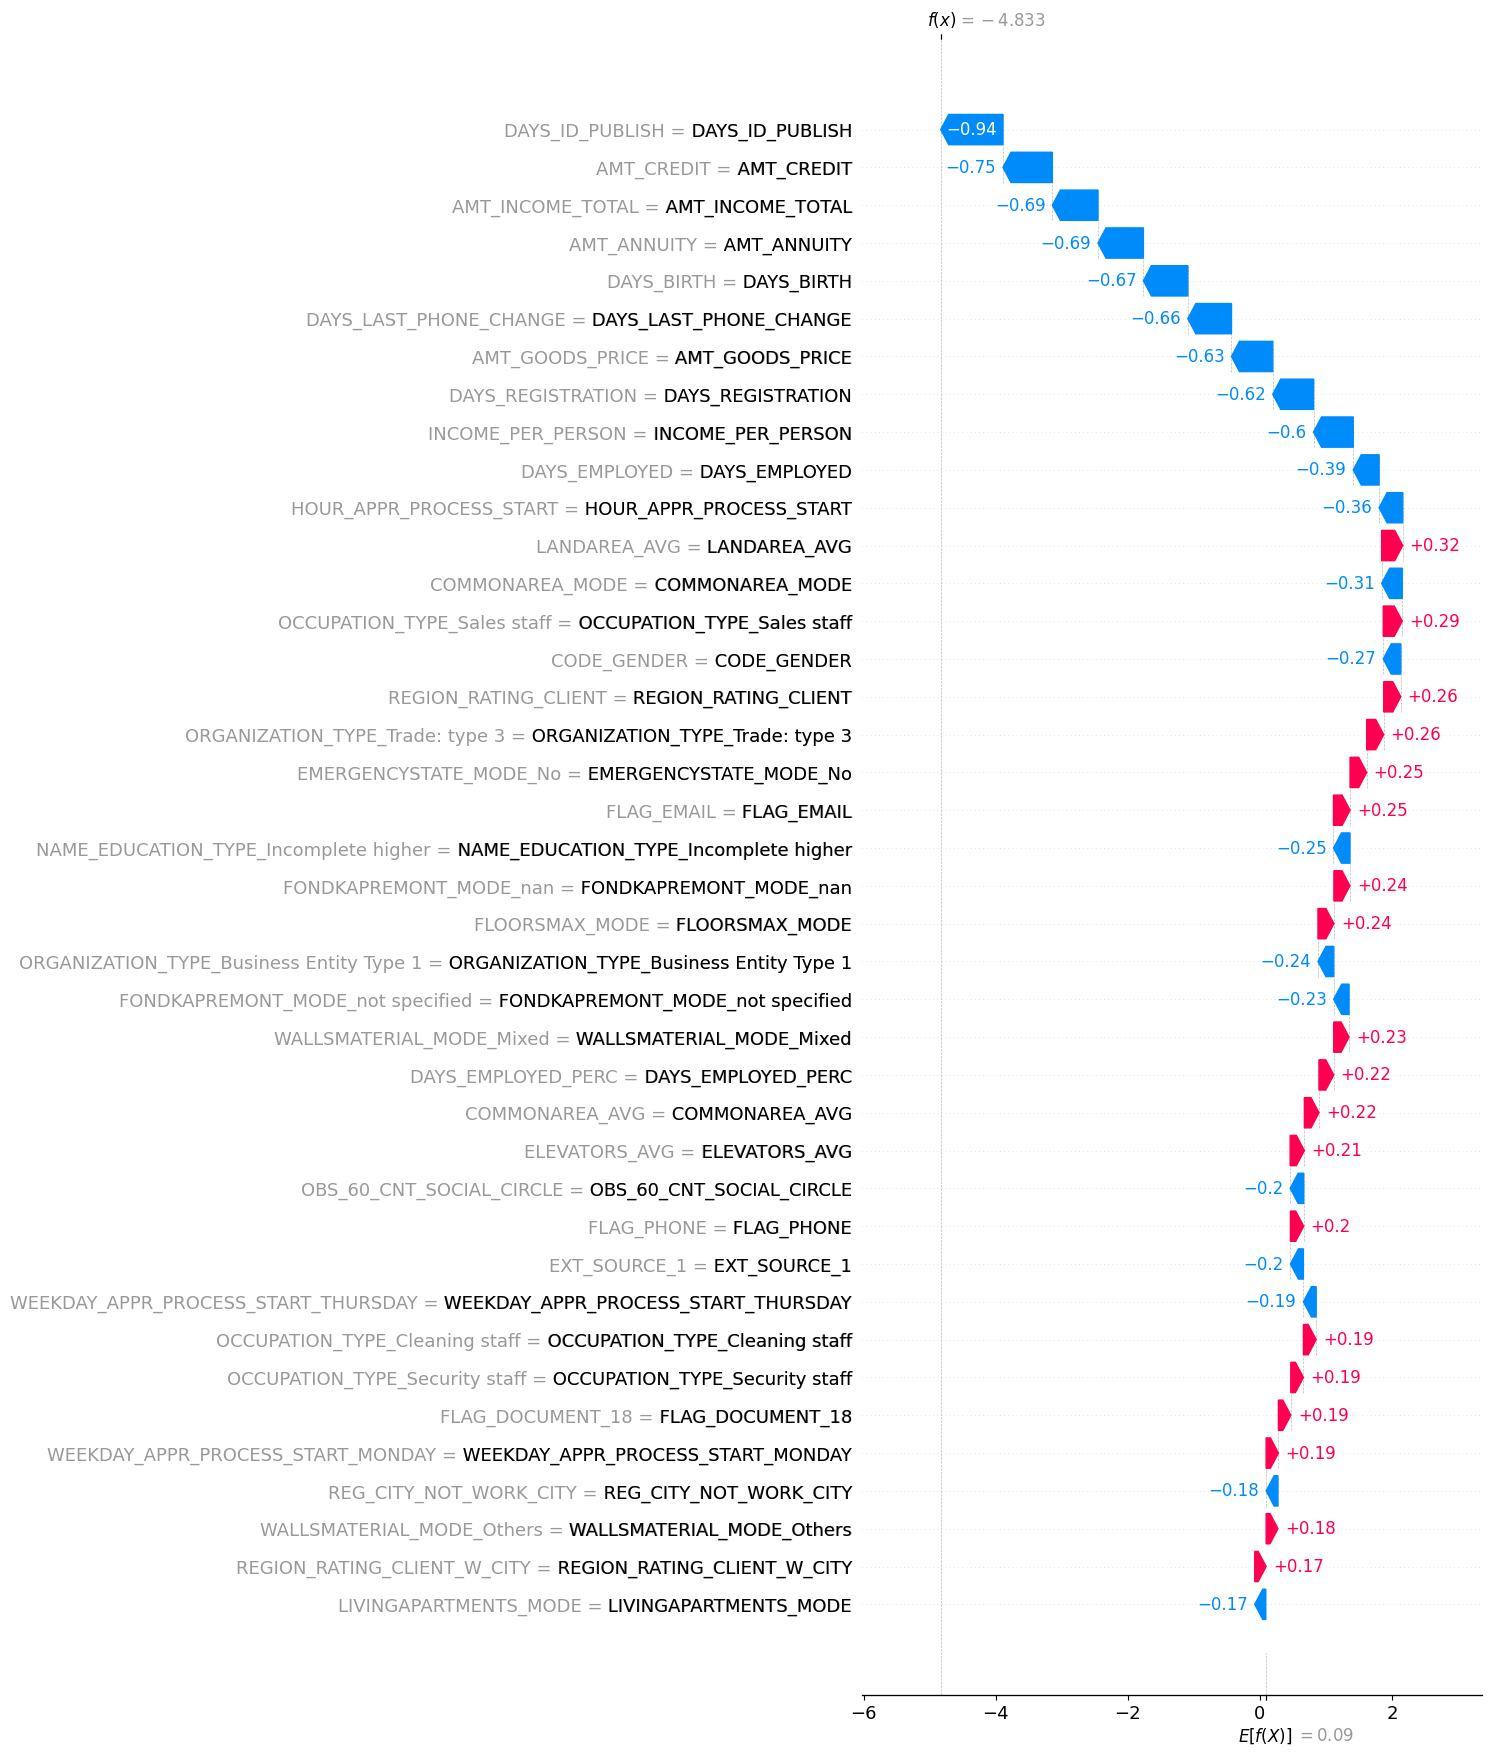

In [104]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Log_reg_model['scl'].transform(X_test))
i=12
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Idem - weight : balanced

In [ ]:
# equilibrage des classes grâce à l'hyperparamètre class_weight='balanced'

In [122]:
import joblib
def Log_reg_balanced(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set[n_fold] = results_valid  
    result_validation = list(result_validation_set.mean(axis=1))  
    
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_balanced_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [123]:
def model2_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression balanced"):
        Log_reg_balanced(df, num_folds=10, stratified=True)    

Threshold optimum: 0.4789473684210526
Threshold optimum: 0.5578947368421052
Threshold optimum: 0.5736842105263158
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.6526315789473685
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.49473684210526314
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.6052631578947368
Threshold optimum - Mean: 0.5547368421052632
           Validation      Train       Test
Accuracy     0.778625   0.791375   0.769500
Cost        52.737500  51.912500  55.000000
F1_score     0.289371   0.291896   0.267091
Precision    0.204333   0.198043   0.177215
Profit      39.512500  40.337500  37.250000
Recall       0.561290   0.554839   0.541935
roc_auc      0.731836   0.768306   0.762895
Run Logistic regression balanced - done in 7s


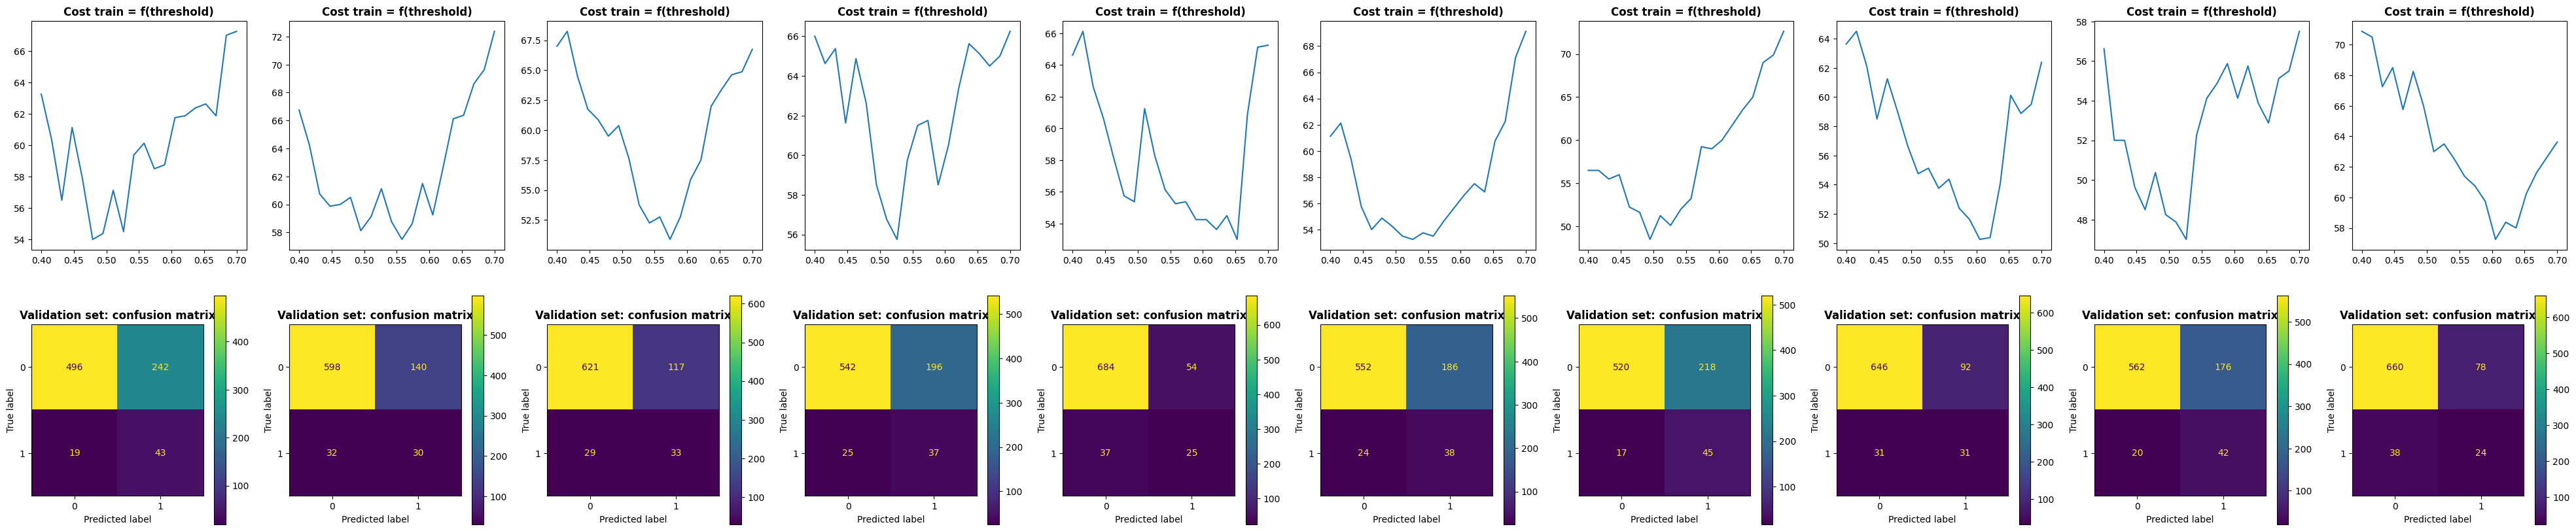

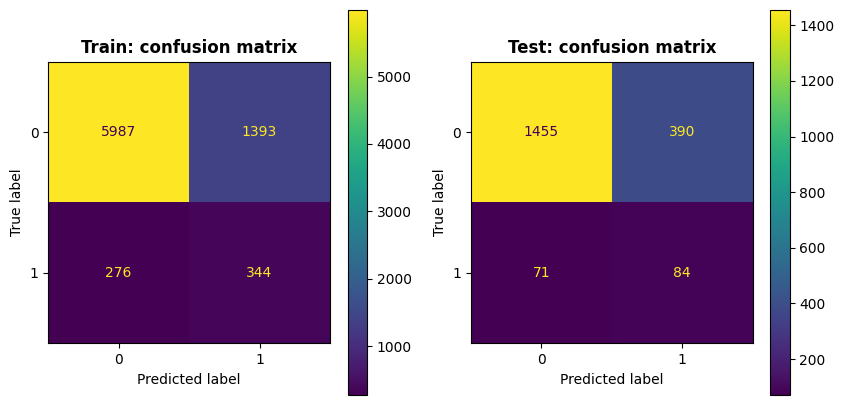

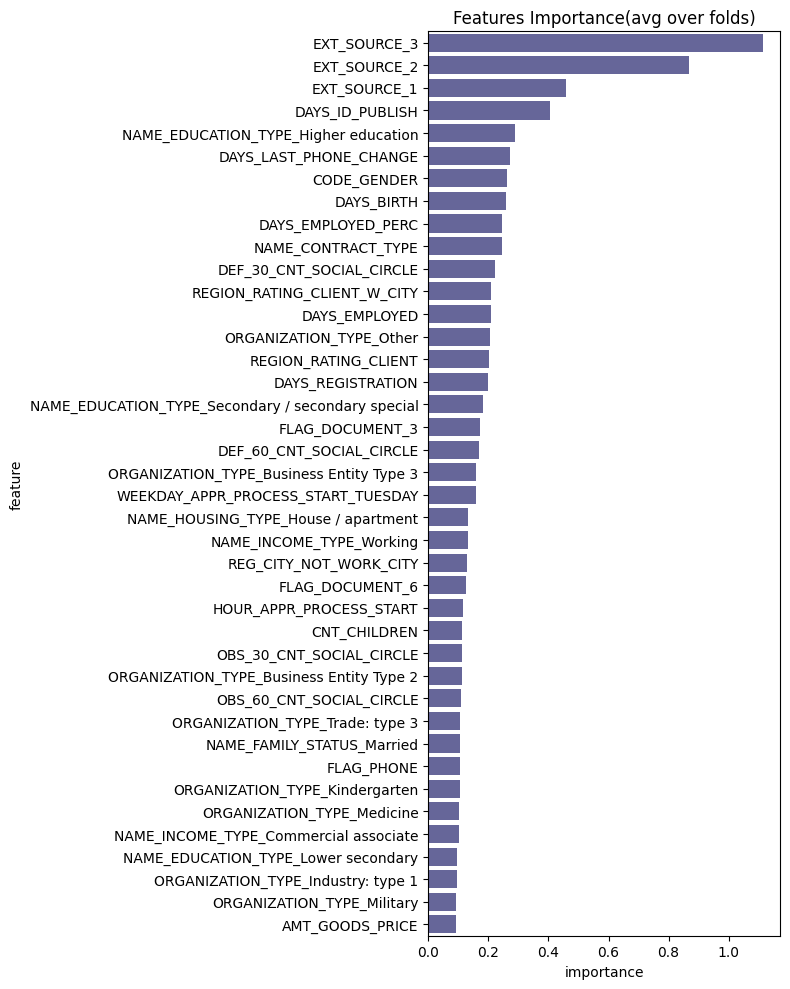

In [124]:
model2_Log_reg(df_10000)

In [127]:
saved_Log_reg_balanced_model = joblib.load('Log_reg_balanced_model.joblib')

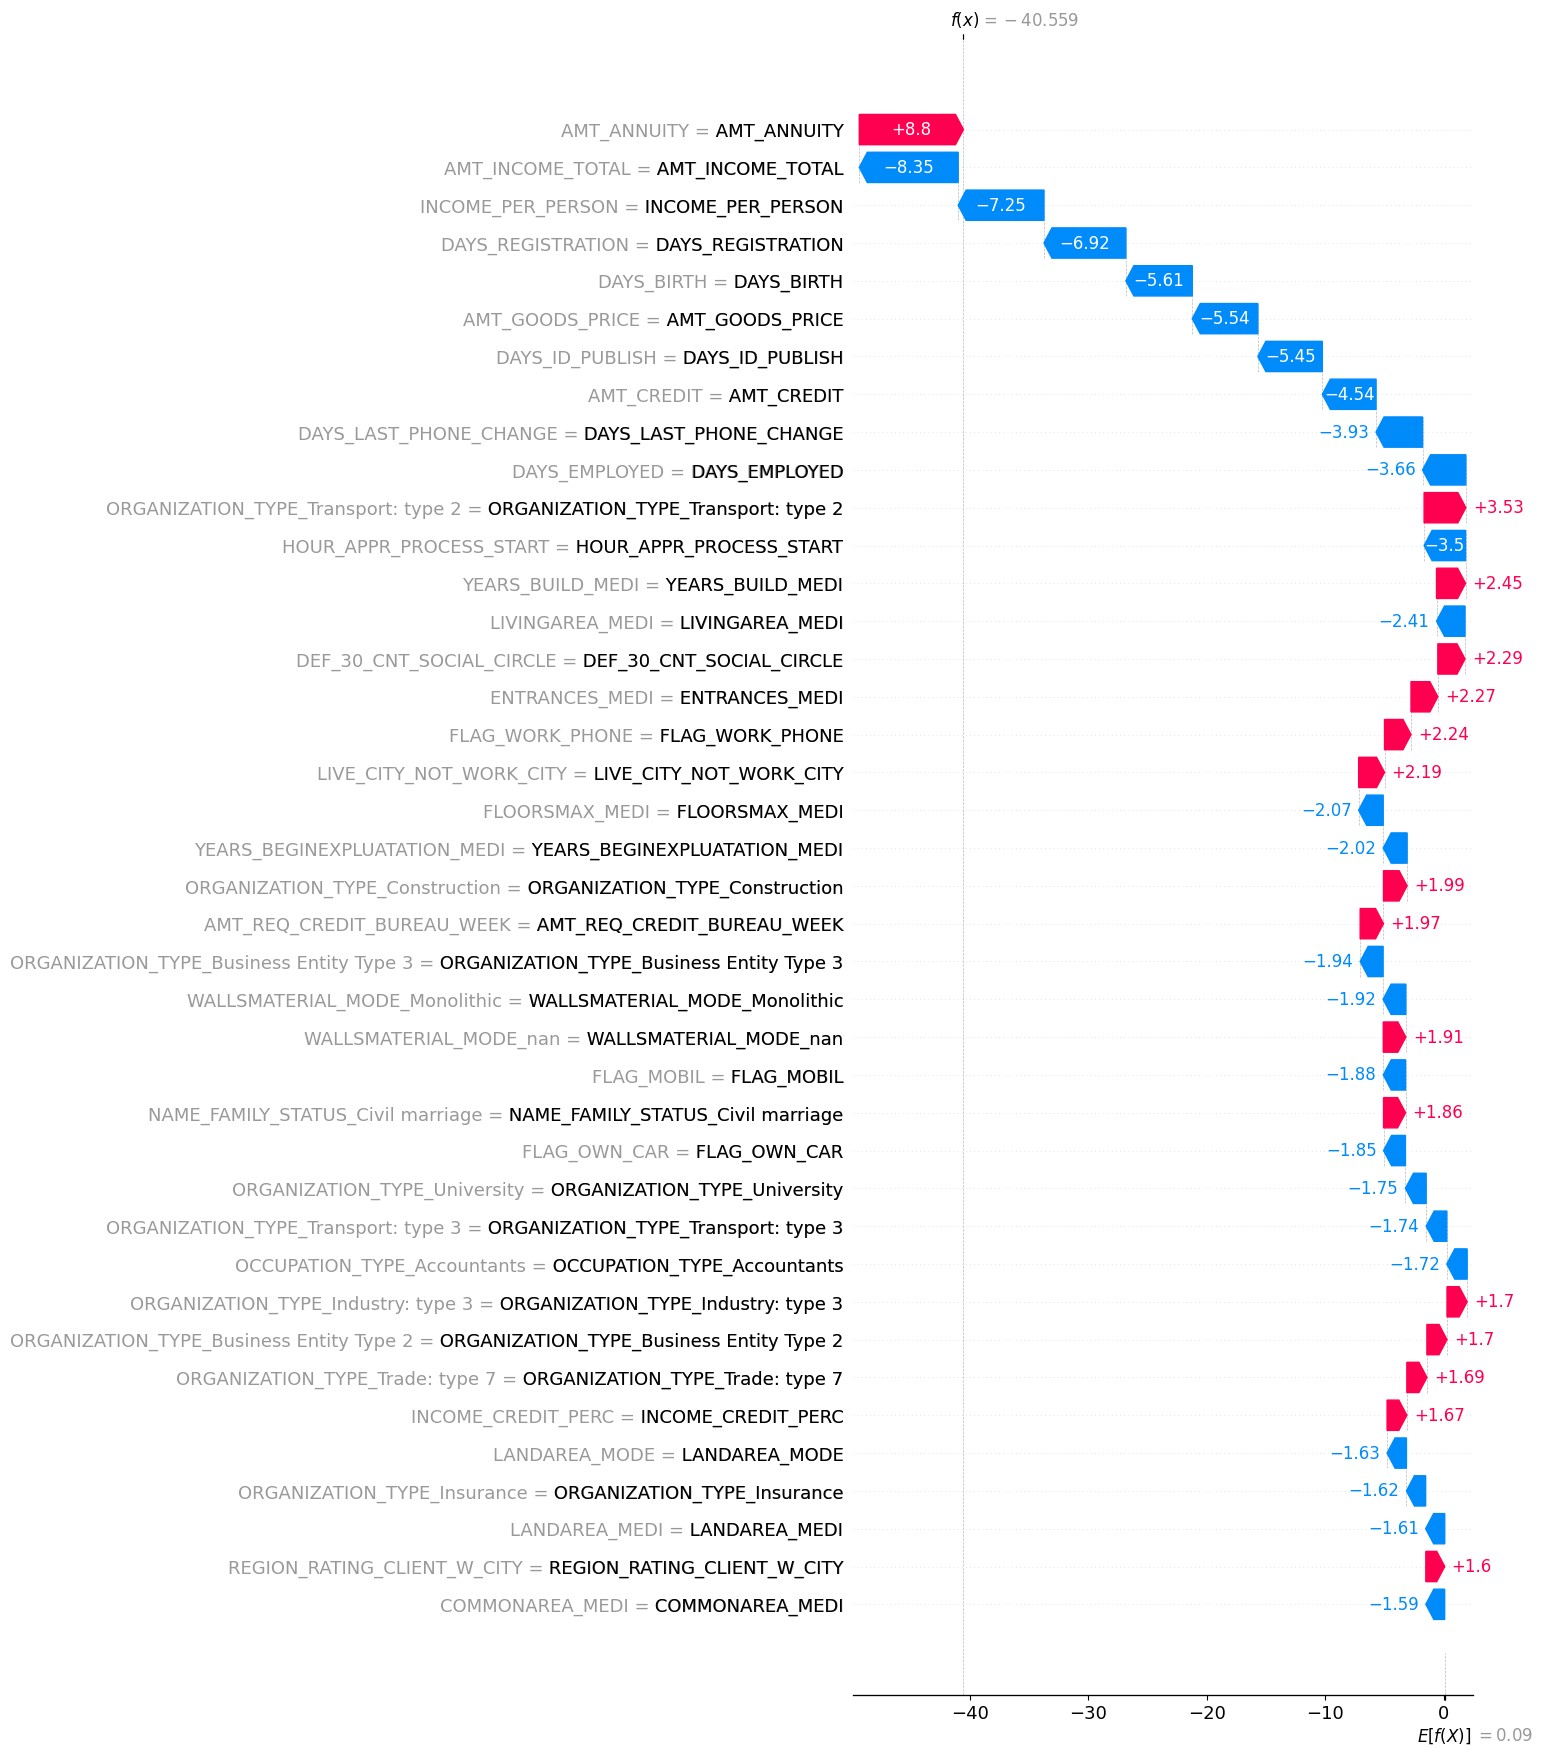

In [133]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_balanced_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Log_reg_balanced_model['scl'].transform(X_test))
i=14
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Idem - Balanced with smote 

In [189]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [130]:
def Log_reg_smote(df, num_folds, stratified = False):
    from imblearn.pipeline import Pipeline
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = LogisticRegression(max_iter=2000) 
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
       # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = LogisticRegression(max_iter=2000) 
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_smote_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [131]:
def model3_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression smote"):
        Log_reg_smote(df, num_folds=10, stratified = True)

Threshold optimum: 0.5421052631578948
Threshold optimum: 0.4473684210526316
Threshold optimum: 0.5736842105263158
Threshold optimum: 0.49473684210526314
Threshold optimum: 0.43157894736842106
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.6684210526315789
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.43157894736842106
Threshold optimum - Mean: 0.521578947368421
           Validation      Train       Test
Accuracy     0.666250   0.834750   0.803000
Cost        59.250000  50.725000  63.800000
F1_score     0.226087   0.323439   0.224409
Precision    0.137809   0.236882   0.161473
Profit      33.000000  41.525000  28.450000
Recall       0.629032   0.509677   0.367742
roc_auc      0.684850   0.785187   0.702834
Run Logistic regression smote - done in 22s


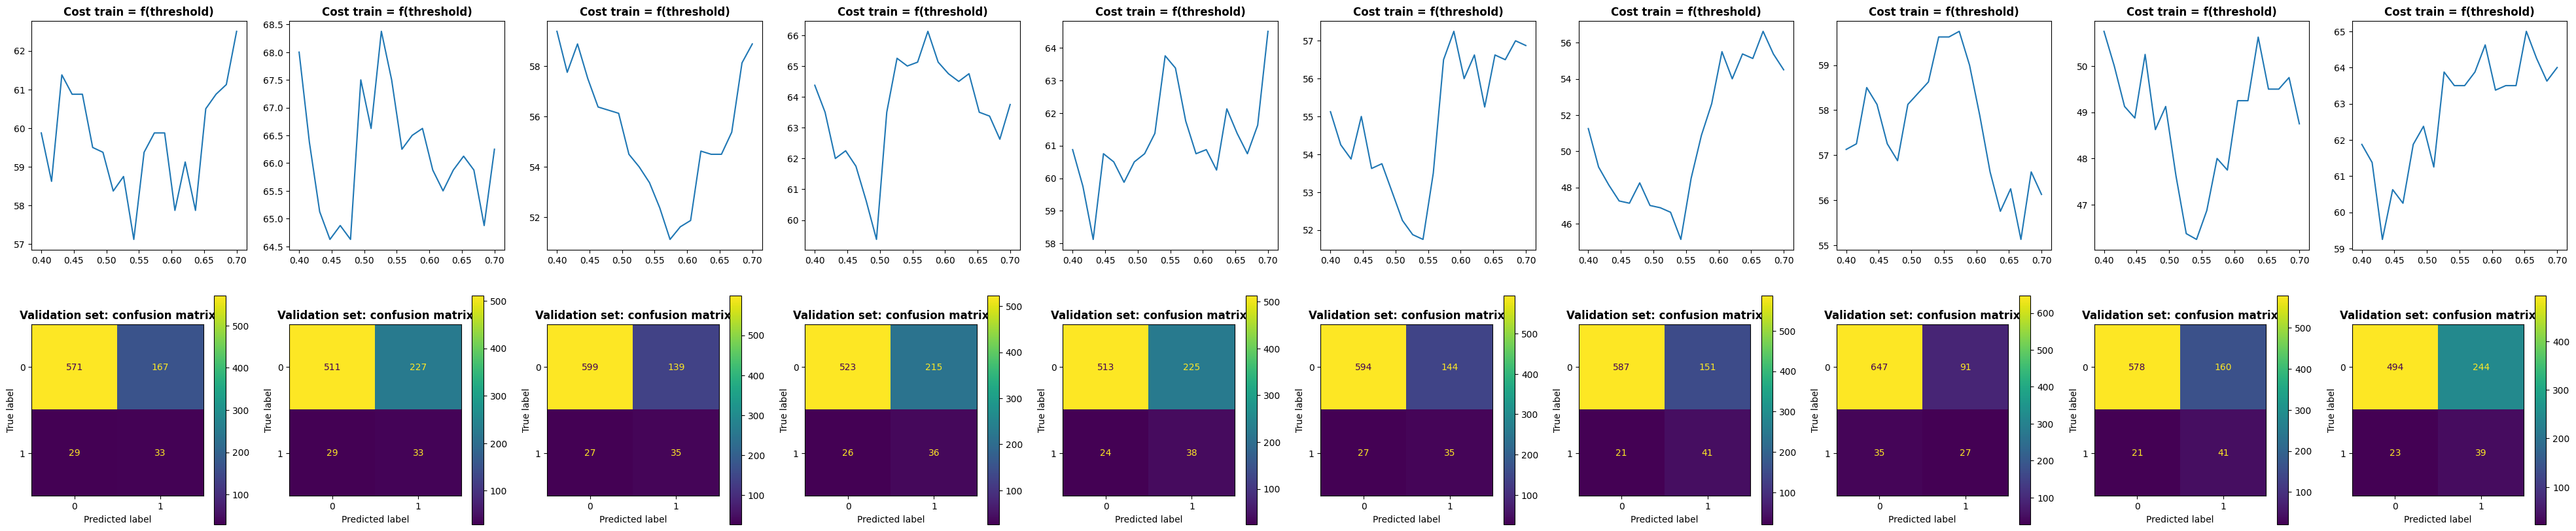

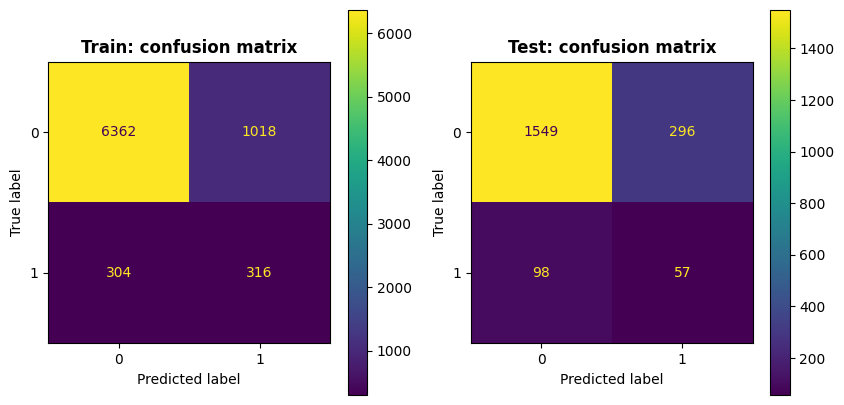

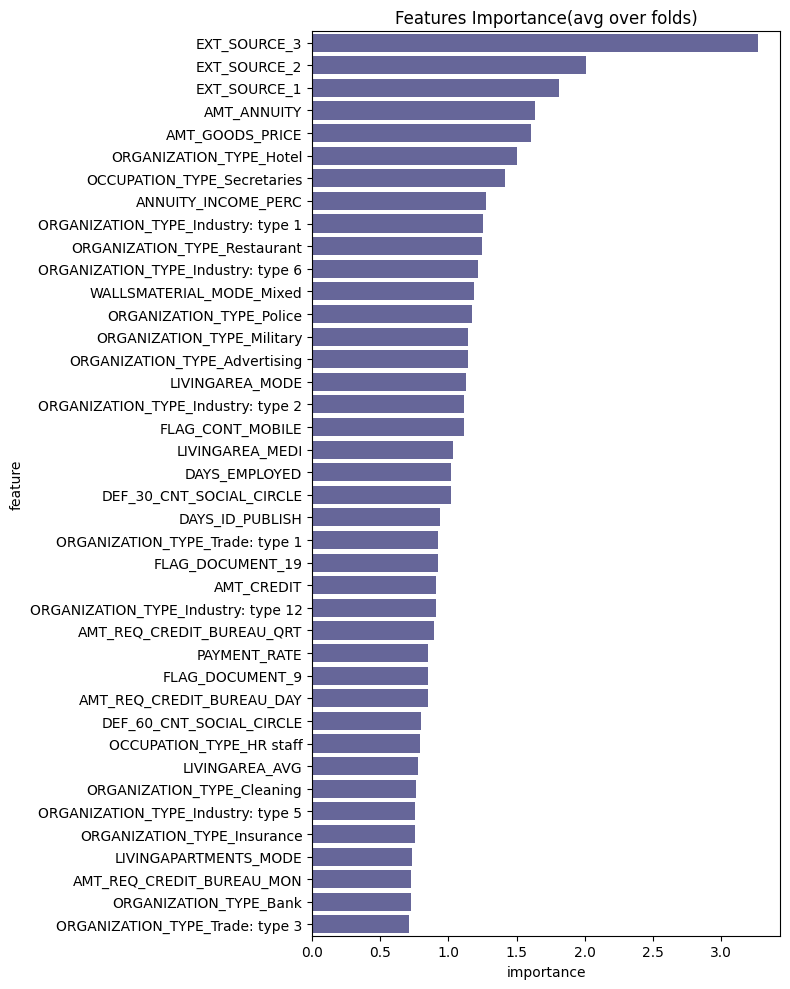

In [132]:
model3_Log_reg(df_10000)

In [134]:
saved_Log_reg_smote_model = joblib.load('Log_reg_smote_model.joblib')

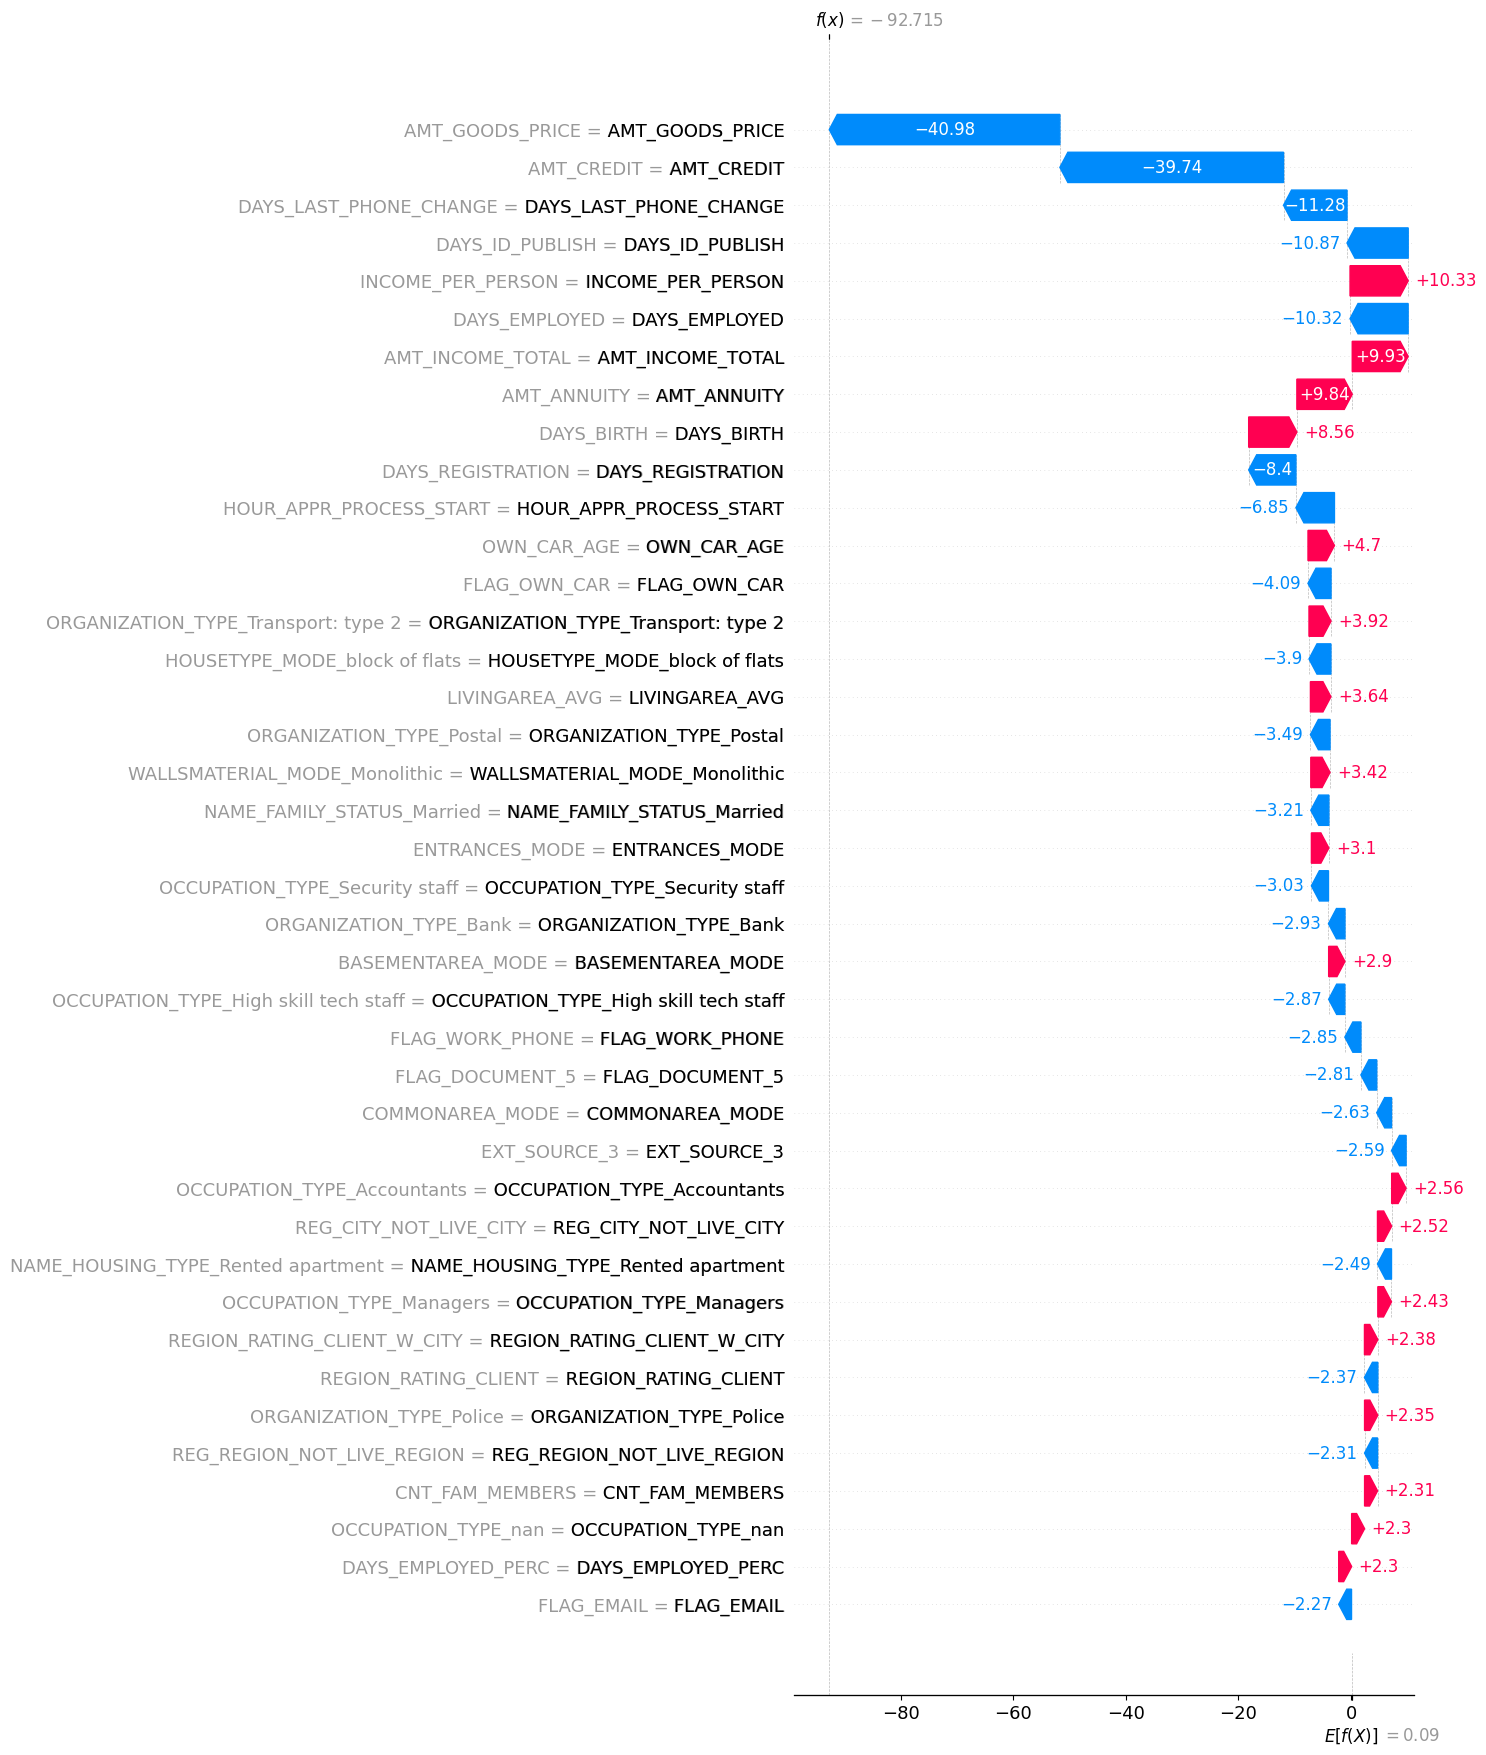

In [135]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_smote_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Log_reg_smote_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

# Model téléchargé
## lightgbm - Balanced

In [153]:
def lightgbm(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, 
            class_weight='balanced')
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
       
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1,
        class_weight='balanced')
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'lightgbm_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [154]:
def model4(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        lightgbm(df, num_folds, stratified)

Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.10789473684210527
           Validation      Train       Test
Accuracy     0.726875   0.907125   0.771500
Cost        57.687500   9.287500  56.150000
F1_score     0.242634   0.625315   0.261712
Precision    0.154525   0.454879   0.174569
Profit      34.562500  82.962500  36.100000
Recall       0.564516   1.000000   0.522581
roc_auc      0.696084   1.000000   0.709163
Run Logistic regression balanced - done in 188s


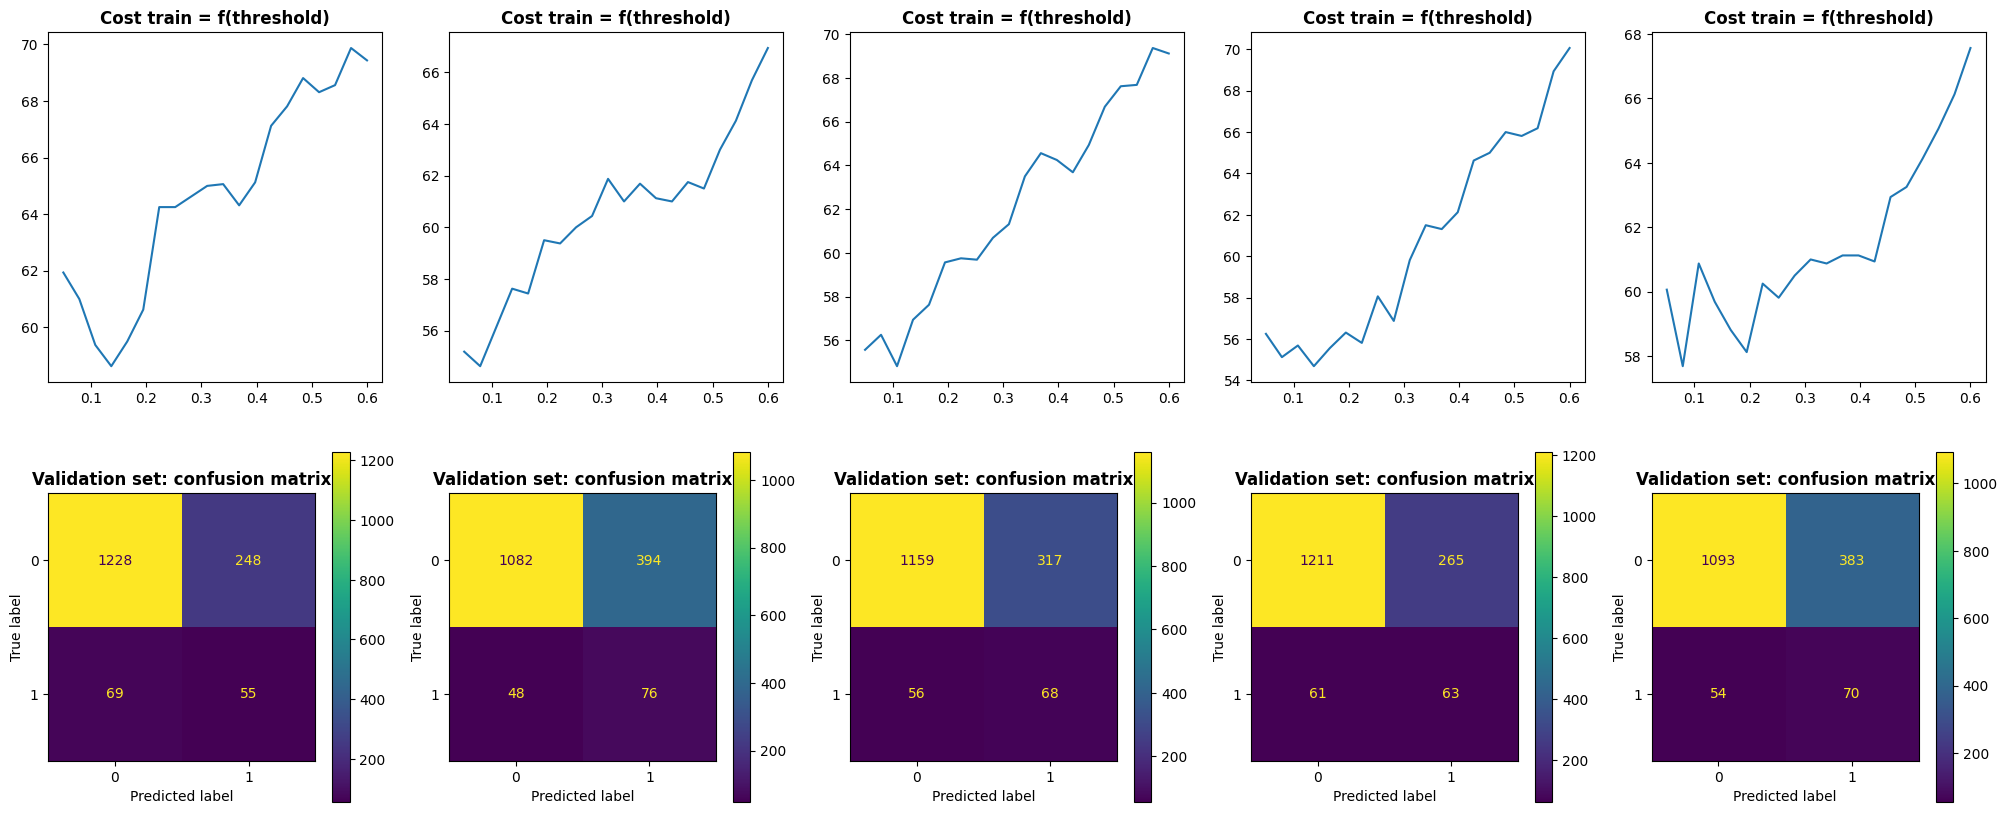

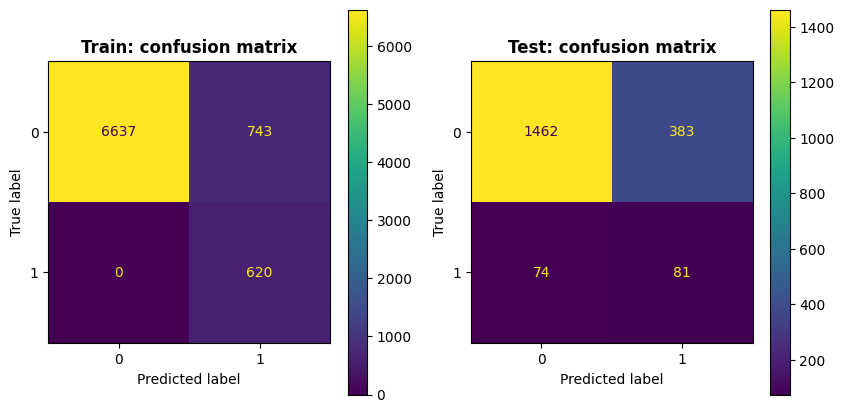

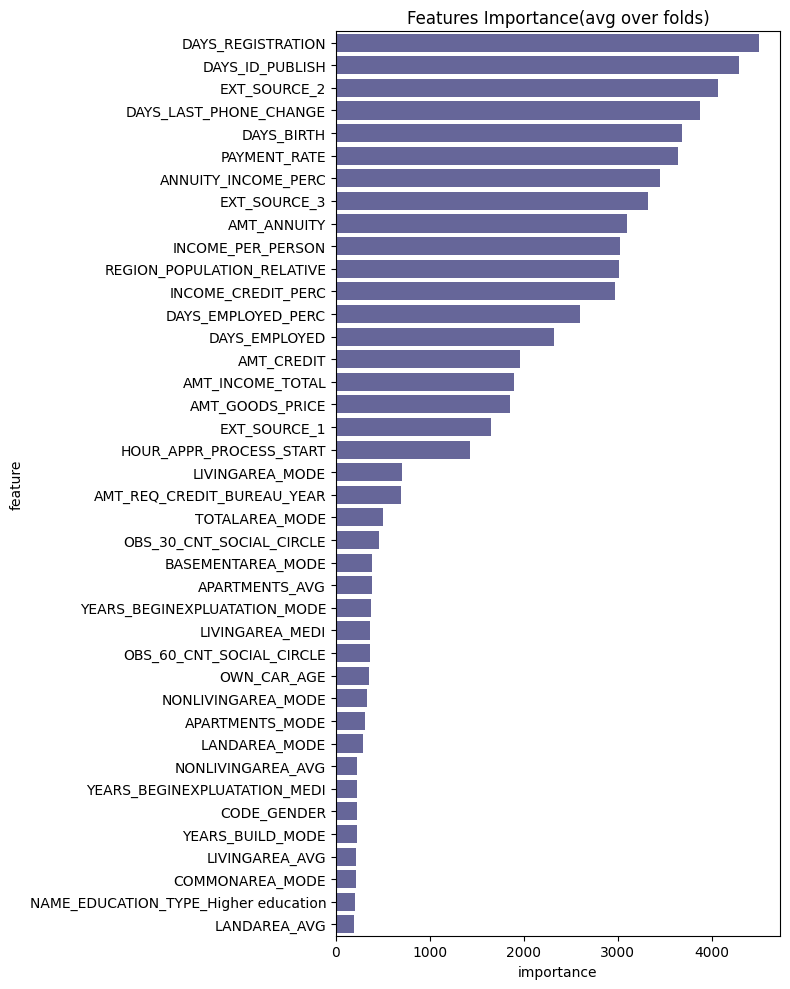

In [155]:
model4(df_10000)

## lightgbm with smote 

In [156]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def lightgbm_smote(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=25,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=4,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")


    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [157]:
def model4_bis(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        lightgbm_smote(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.05
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.05
Threshold optimum: 0.05
Threshold optimum - Mean: 0.06157894736842105
           Validation      Train       Test
Accuracy     0.694375   0.819250   0.702500
Cost        58.687500  18.075000  57.650000
F1_score     0.232339   0.461653   0.238156
Precision    0.144250   0.300097   0.148562
Profit      33.562500  74.175000  34.600000
Recall       0.596774   1.000000   0.600000
roc_auc      0.702050   0.997236   0.715049
Run Logistic regression balanced - done in 245s


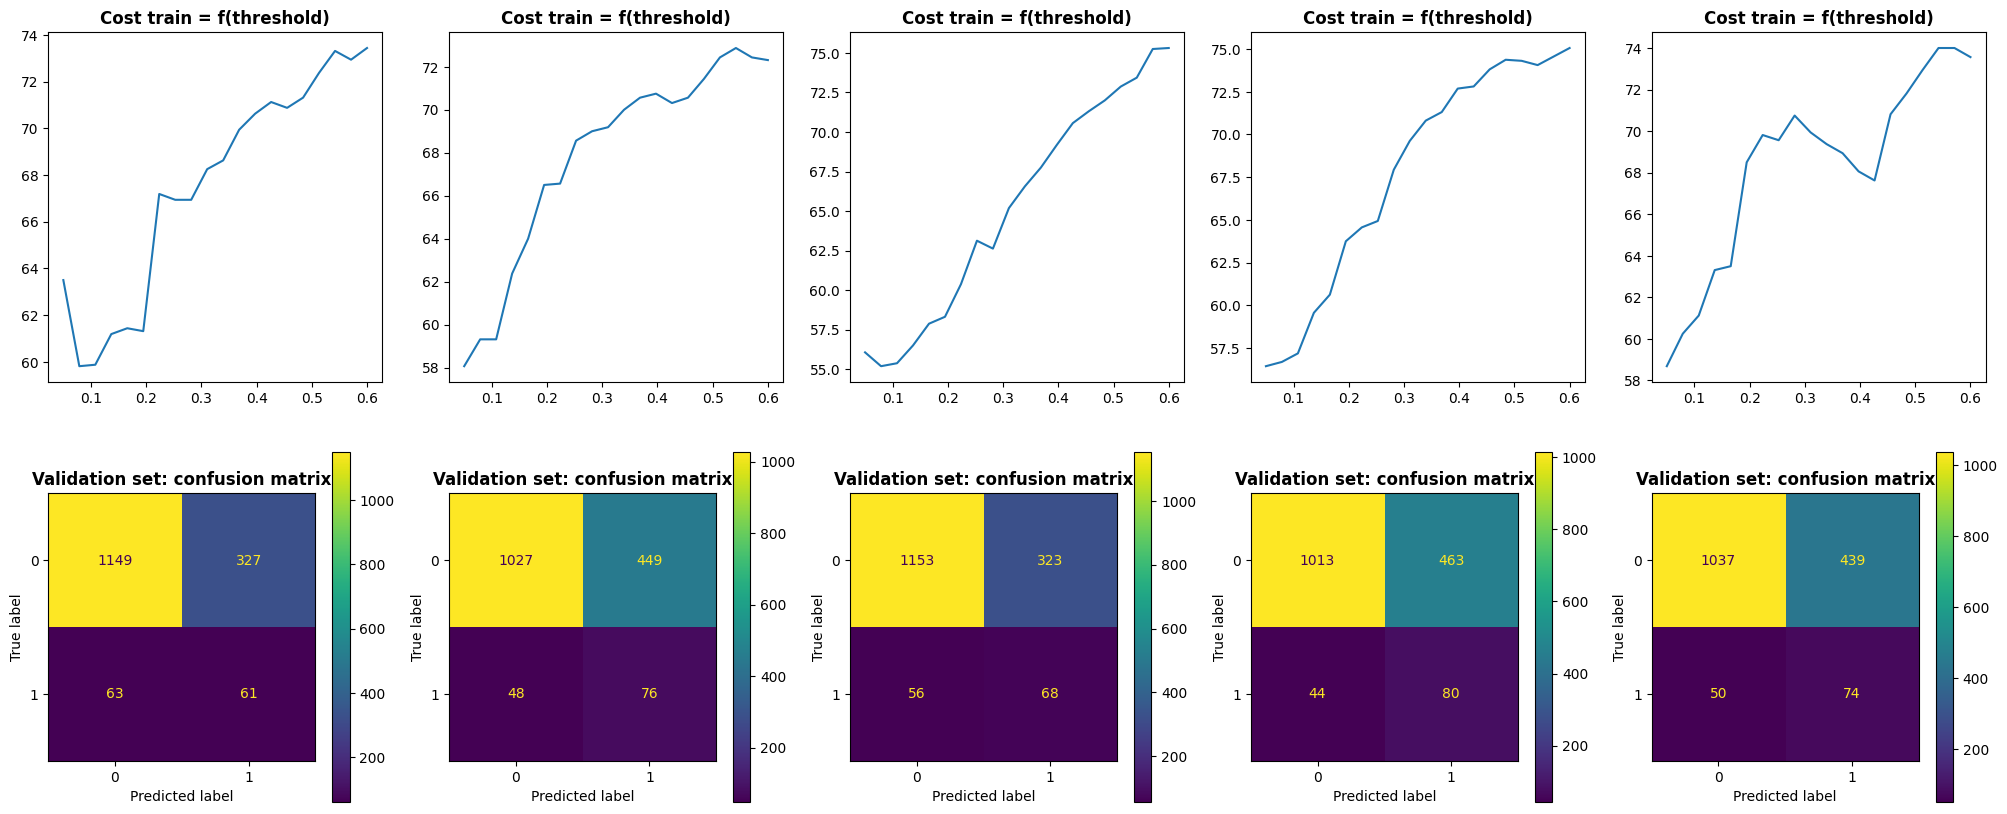

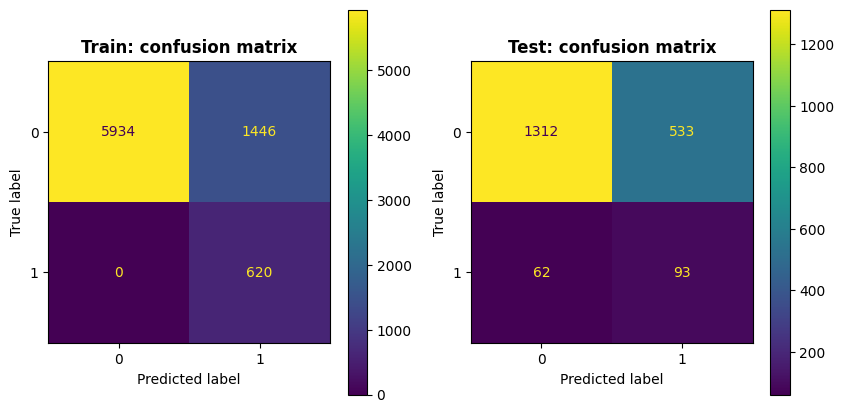

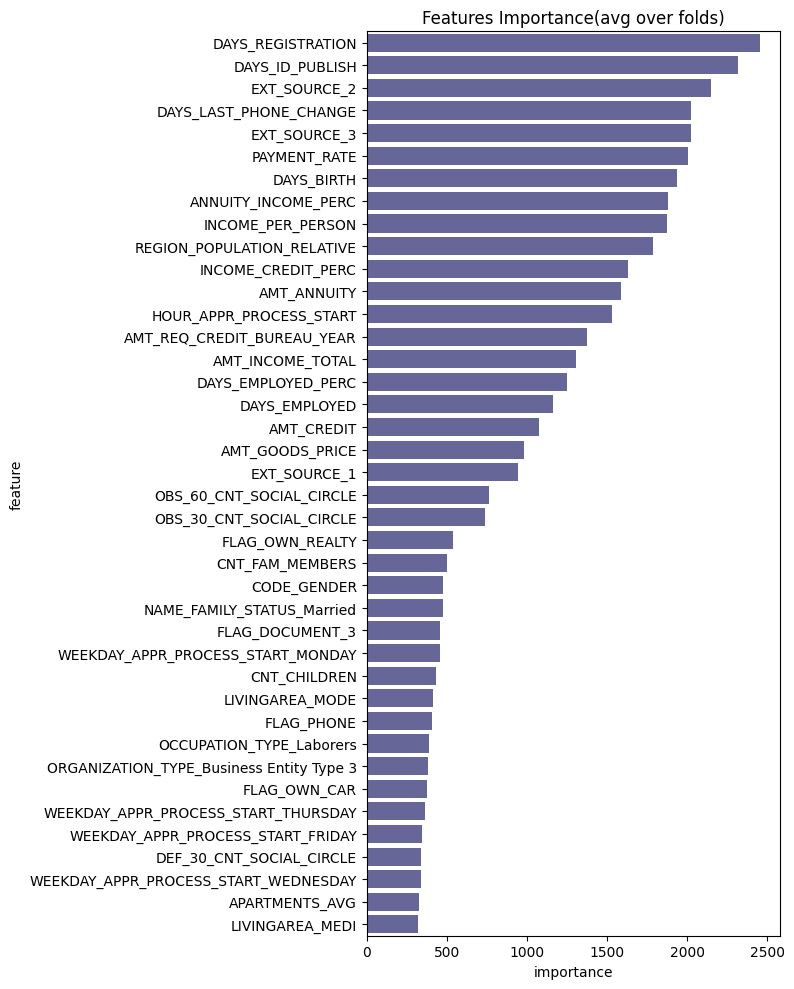

In [158]:
model4_bis(df_10000)

In [84]:
# Important overfitting

## lightgbm calibrated 

In [201]:
from sklearn.calibration import CalibratedClassifierCV
def lightgbm_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")


    scl = MinMaxScaler()
    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation,  results_test))
    

In [202]:
def model4_qua(df, num_folds=10, stratified = True):
    with timer("Run lightgbm_calibrated"):
        lightgbm_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.16578947368421051
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.10789473684210527
           Validation      Train       Test
Accuracy     0.672500   0.879125   0.773500
Cost        56.375000  12.312500  58.200000
F1_score     0.238372   0.561053   0.251240
Precision    0.145390   0.390398   0.168889
Profit      35.875000  79.937500  34.050000
Recall       0.661290   0.996774   0.490323
roc_auc      0.699340   0.993953   0.720995
Run lightgbm_calibrated - done in 633s


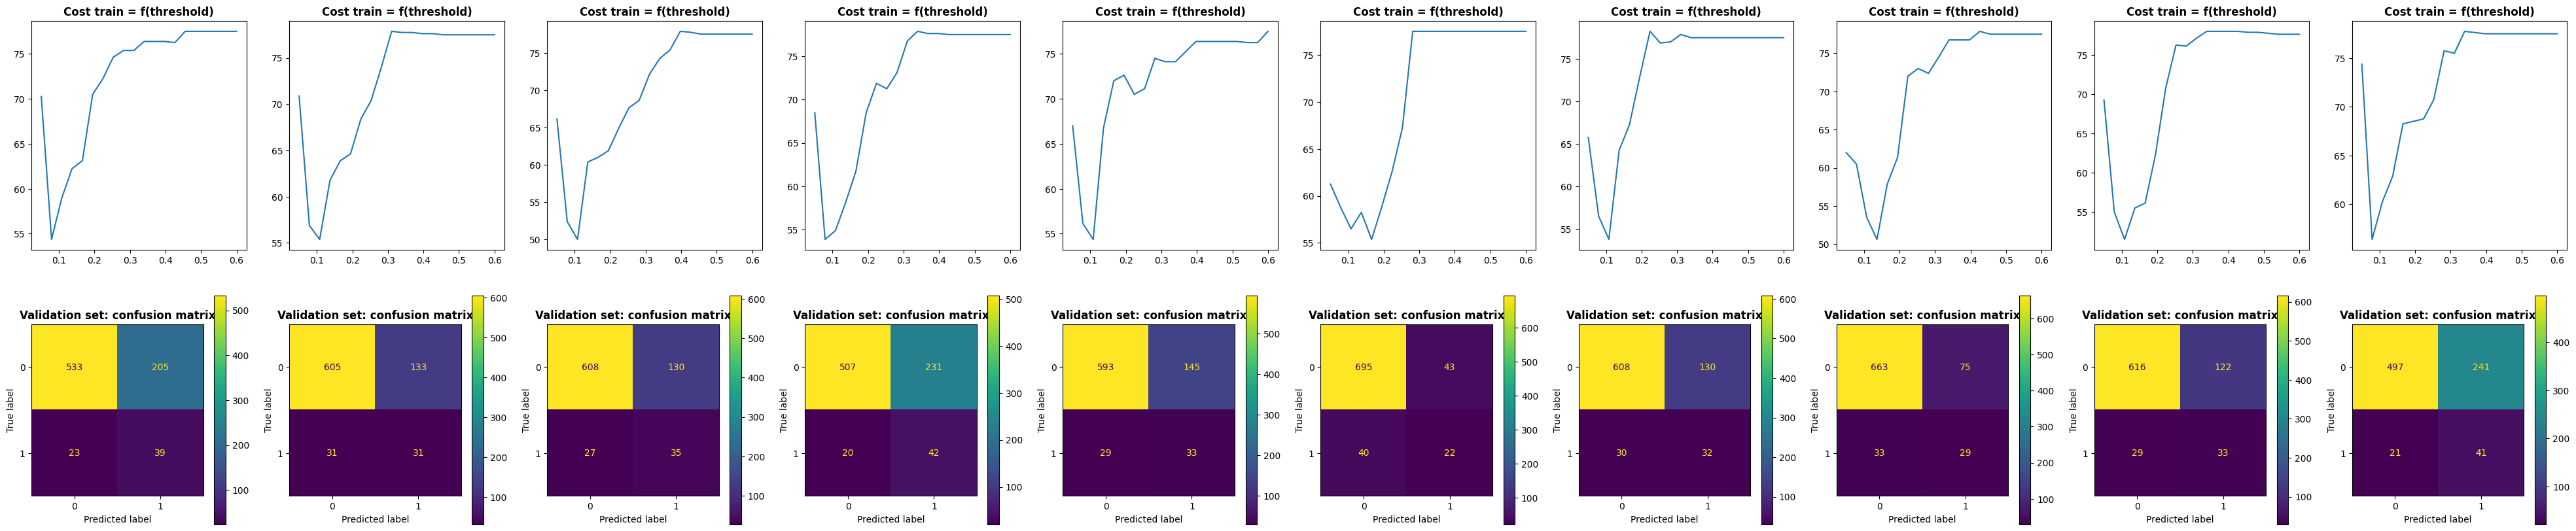

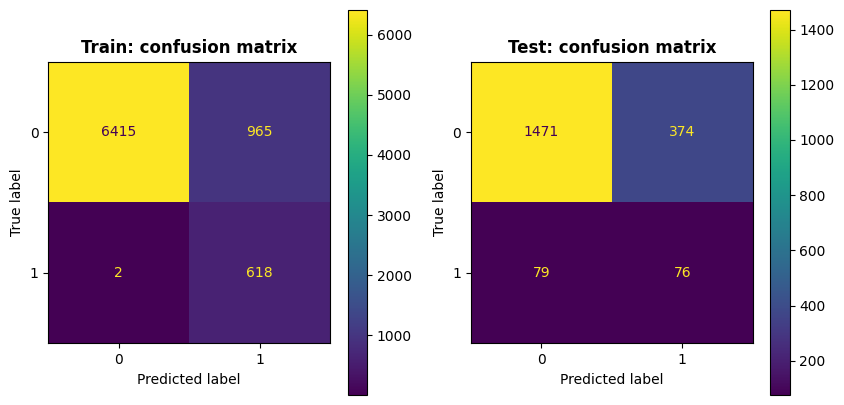

In [203]:
model4_qua(df_10000)

# SVM

In [794]:
def SVC_calibrated(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.coef_[0]
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'saved_SVC_calibrated_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    

In [888]:
def model9(df, num_folds=10, stratified = True):
    with timer("Run SVC_calibrated"):
        SVC_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.08763157894736842
           Validation      Train       Test
Accuracy     0.660000   0.800250   0.789000
Cost        68.875000  60.925000  72.850000
F1_score     0.175758   0.224272   0.235507
Precision    0.107407   0.157679   0.174731
Profit      23.625000  31.637500  18.150000
Recall       0.483333   0.388235   0.361111
roc_auc      0.609932   0.685251   0.650777
Run SVC_calibrated - done in 214s


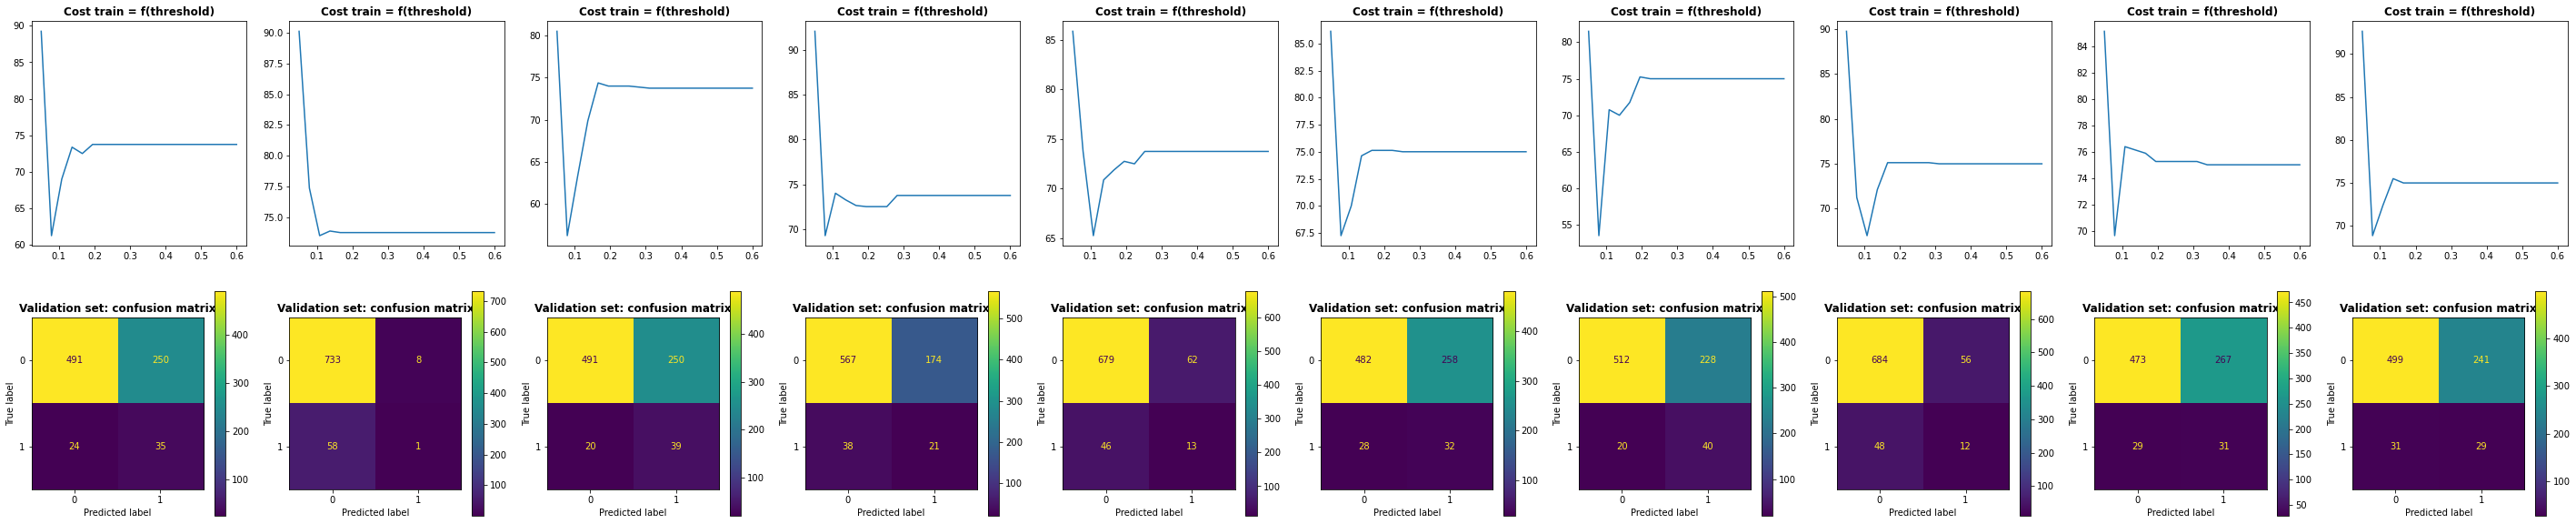

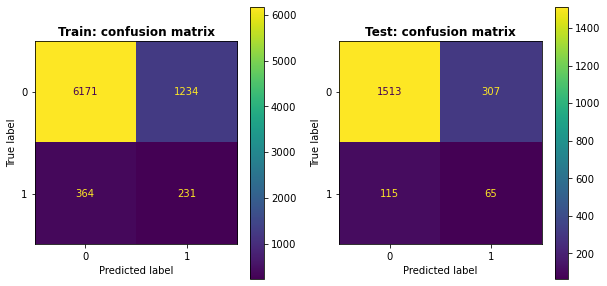

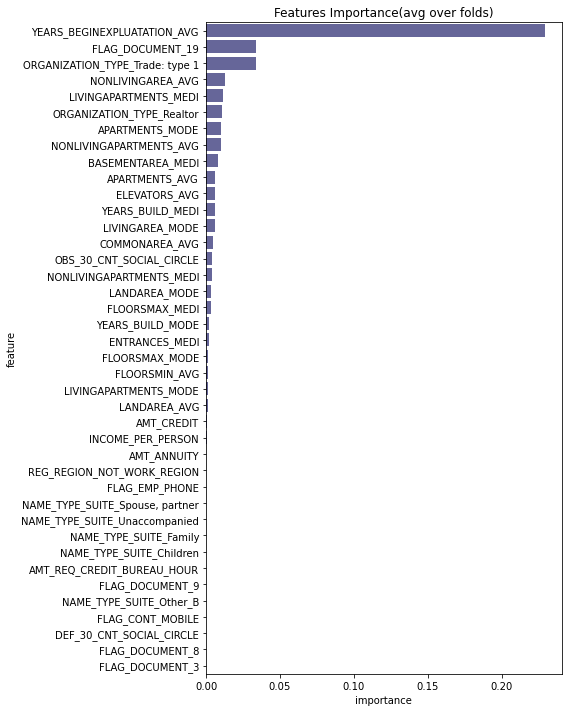

In [889]:
model9(df_10000)

In [797]:
saved_SVC_calibrated_model = joblib.load('saved_SVC_calibrated_model.joblib')

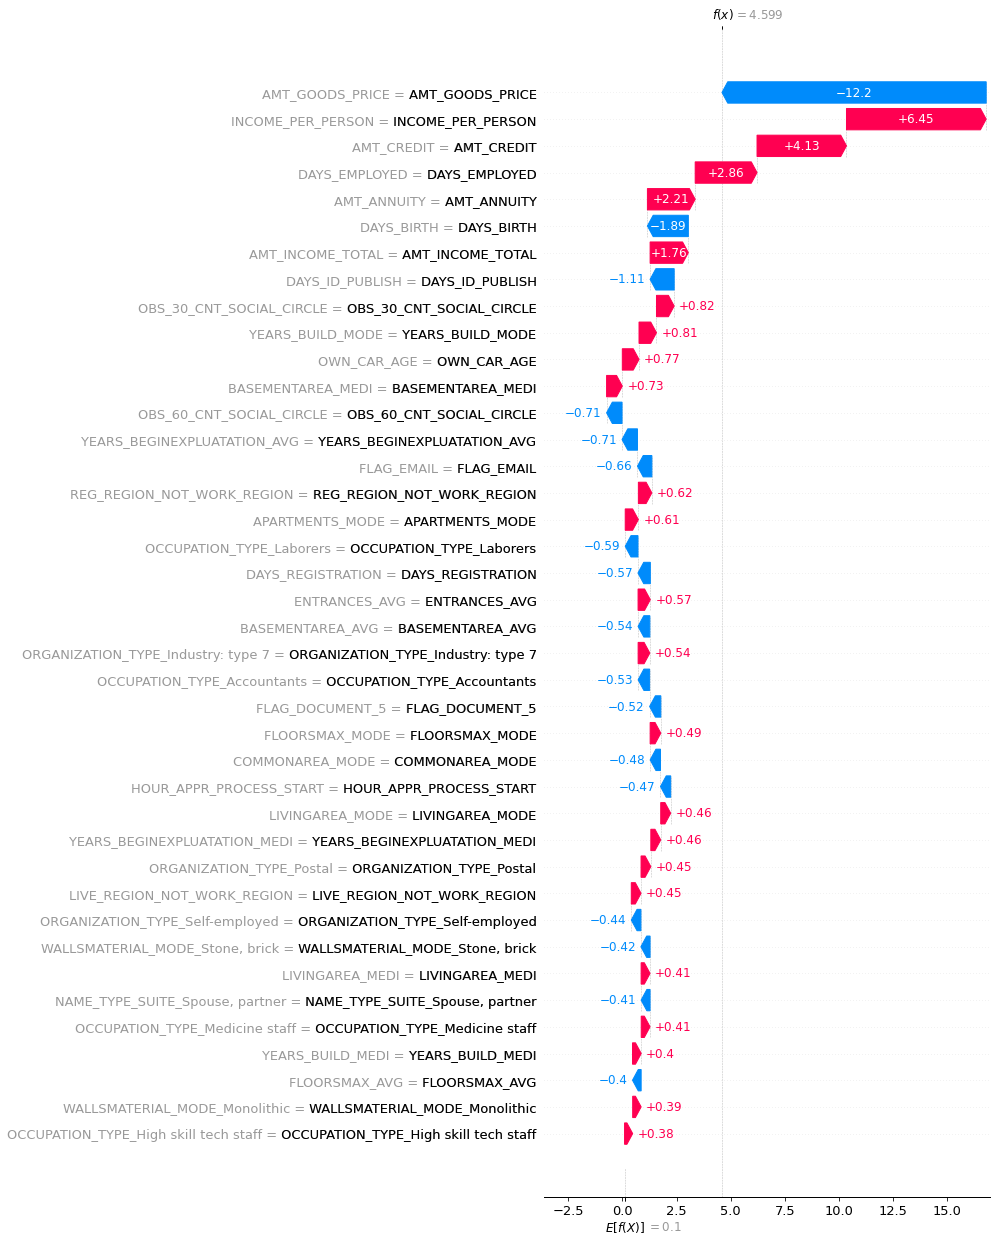

In [799]:
sample = shap.utils.sample(X_train, nsamples=50)
explainer = shap.KernelExplainer(saved_SVC_calibrated_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_SVC_calibrated_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

In [800]:
import shap
import random
def SVC_rbf(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'SVC_rbf_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
    

In [801]:
def model_SVC_rbf(df, num_folds=5, stratified = True):
    with timer("Run SVC_rbf"):
        SVC_rbf(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.0905263157894737
           Validation      Train       Test
Accuracy     0.653750   0.901125   0.762500
Cost        61.062500  14.950000  60.650000
F1_score     0.206304   0.581703   0.292101
Precision    0.124352   0.424383   0.199593
Profit      31.500000  77.612500  30.350000
Recall       0.605042   0.924370   0.544444
roc_auc      0.677588   0.971328   0.721850
Run SVC_rbf - done in 102s


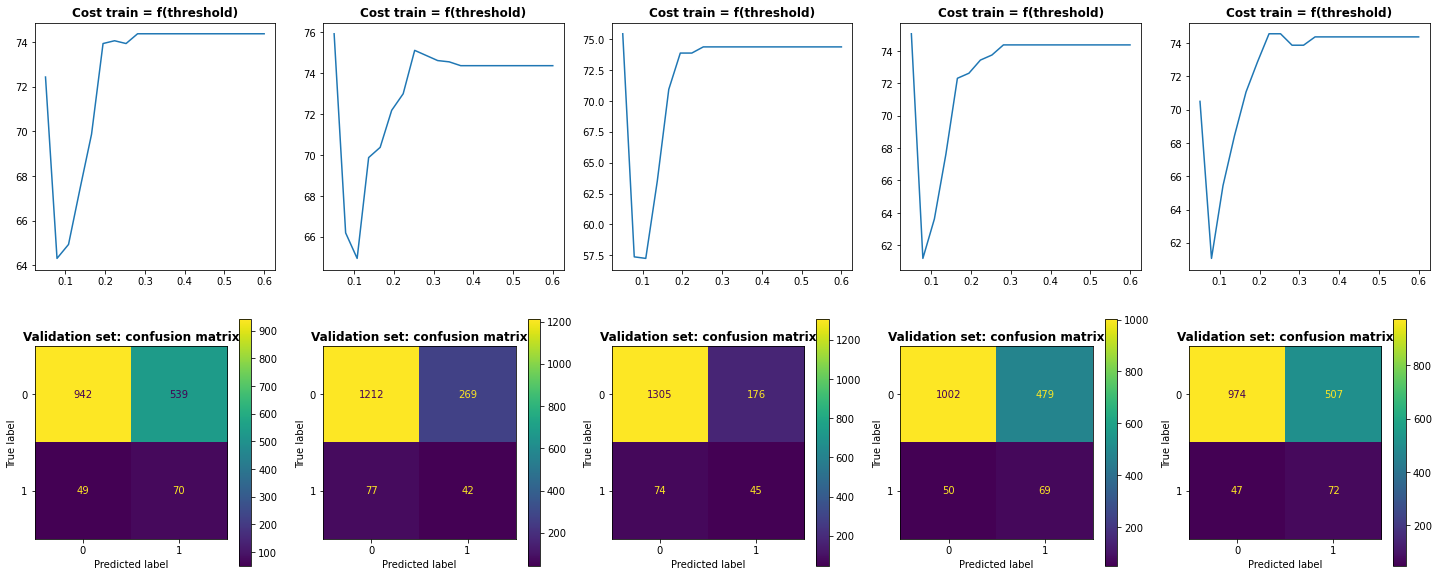

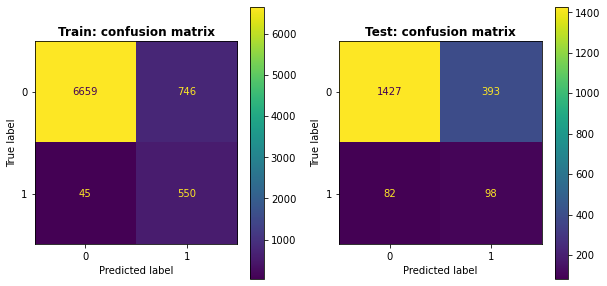

In [802]:
model_SVC_rbf(df_10000)

In [803]:
saved_SVC_rbf_model = joblib.load('SVC_rbf_model.joblib')

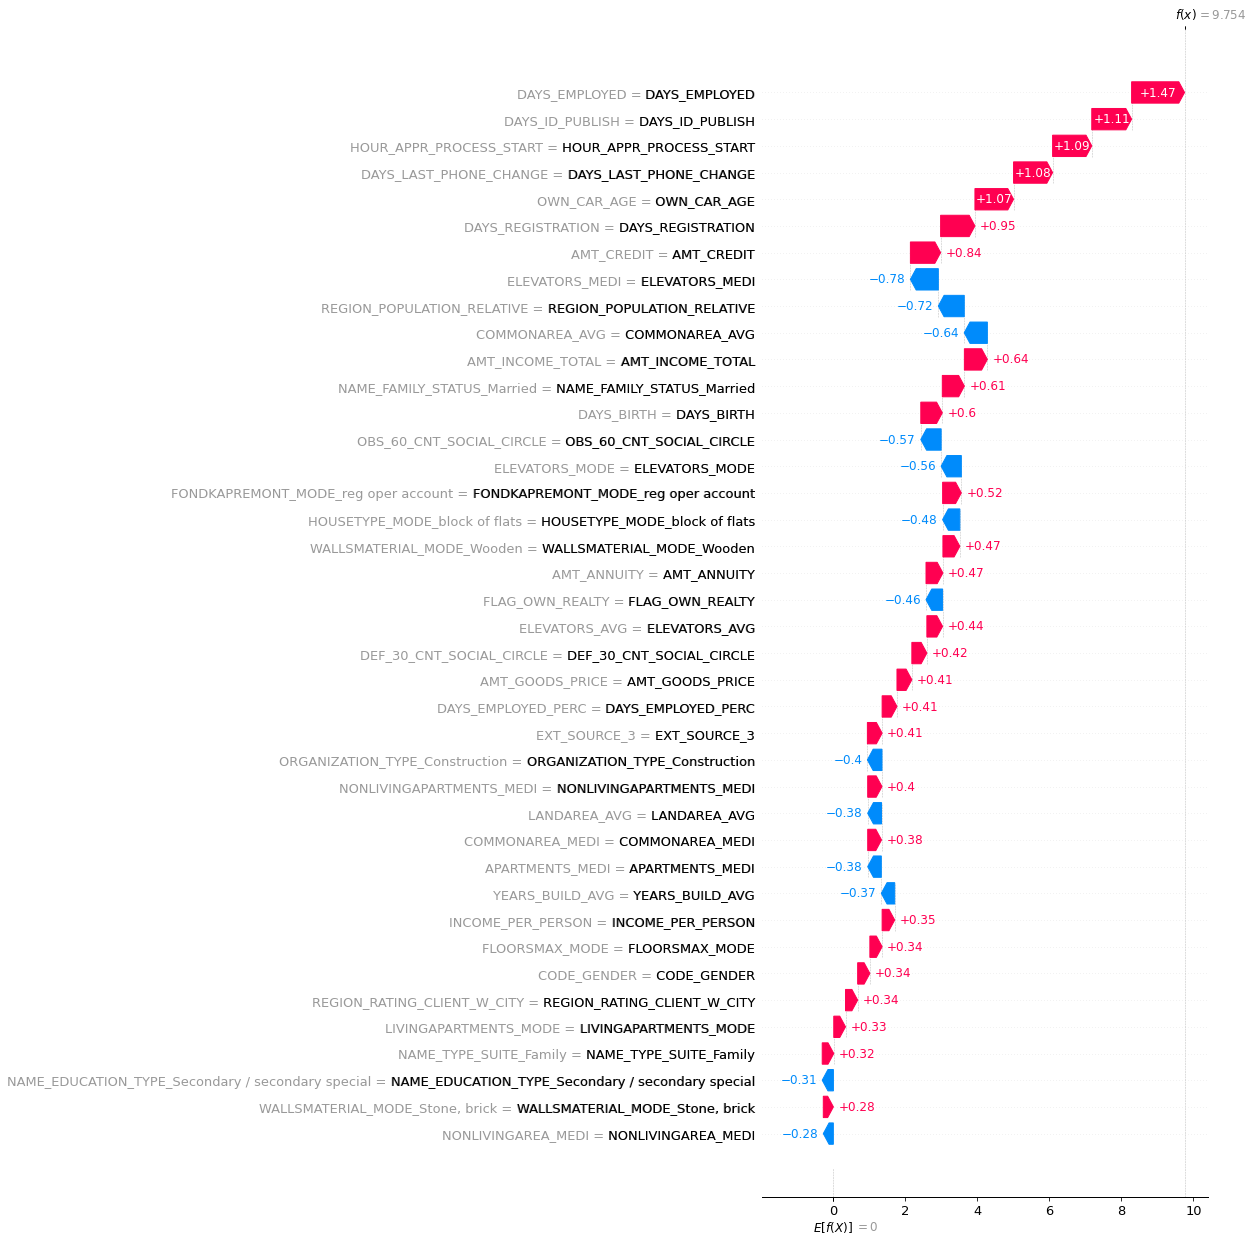

In [804]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.KernelExplainer(saved_SVC_rbf_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_SVC_rbf_model['scl'].transform(X_test))
i=861
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

# Tree
## Decision Tree

In [204]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=4, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
            
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.2, 0.7, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=40, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'Decision_Tree_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    
    

In [205]:
def model_decision_tree_balanced(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        Decision_Tree(df, num_folds, stratified)

Threshold optimum: 0.5947368421052632
Threshold optimum: 0.5947368421052632
Threshold optimum: 0.4631578947368421
Threshold optimum: 0.5421052631578946
Threshold optimum: 0.5947368421052632
Threshold optimum - Mean: 0.5578947368421053
           Validation      Train       Test
Accuracy     0.743750   0.942625   0.816000
Cost        56.562500   5.737500  69.700000
F1_score     0.251825   0.729841   0.182222
Precision    0.162736   0.574606   0.138983
Profit      35.687500  86.512500  22.550000
Recall       0.556452   1.000000   0.264516
roc_auc      0.681137   0.991732   0.566168
Run Logistic regression balanced - done in 5s


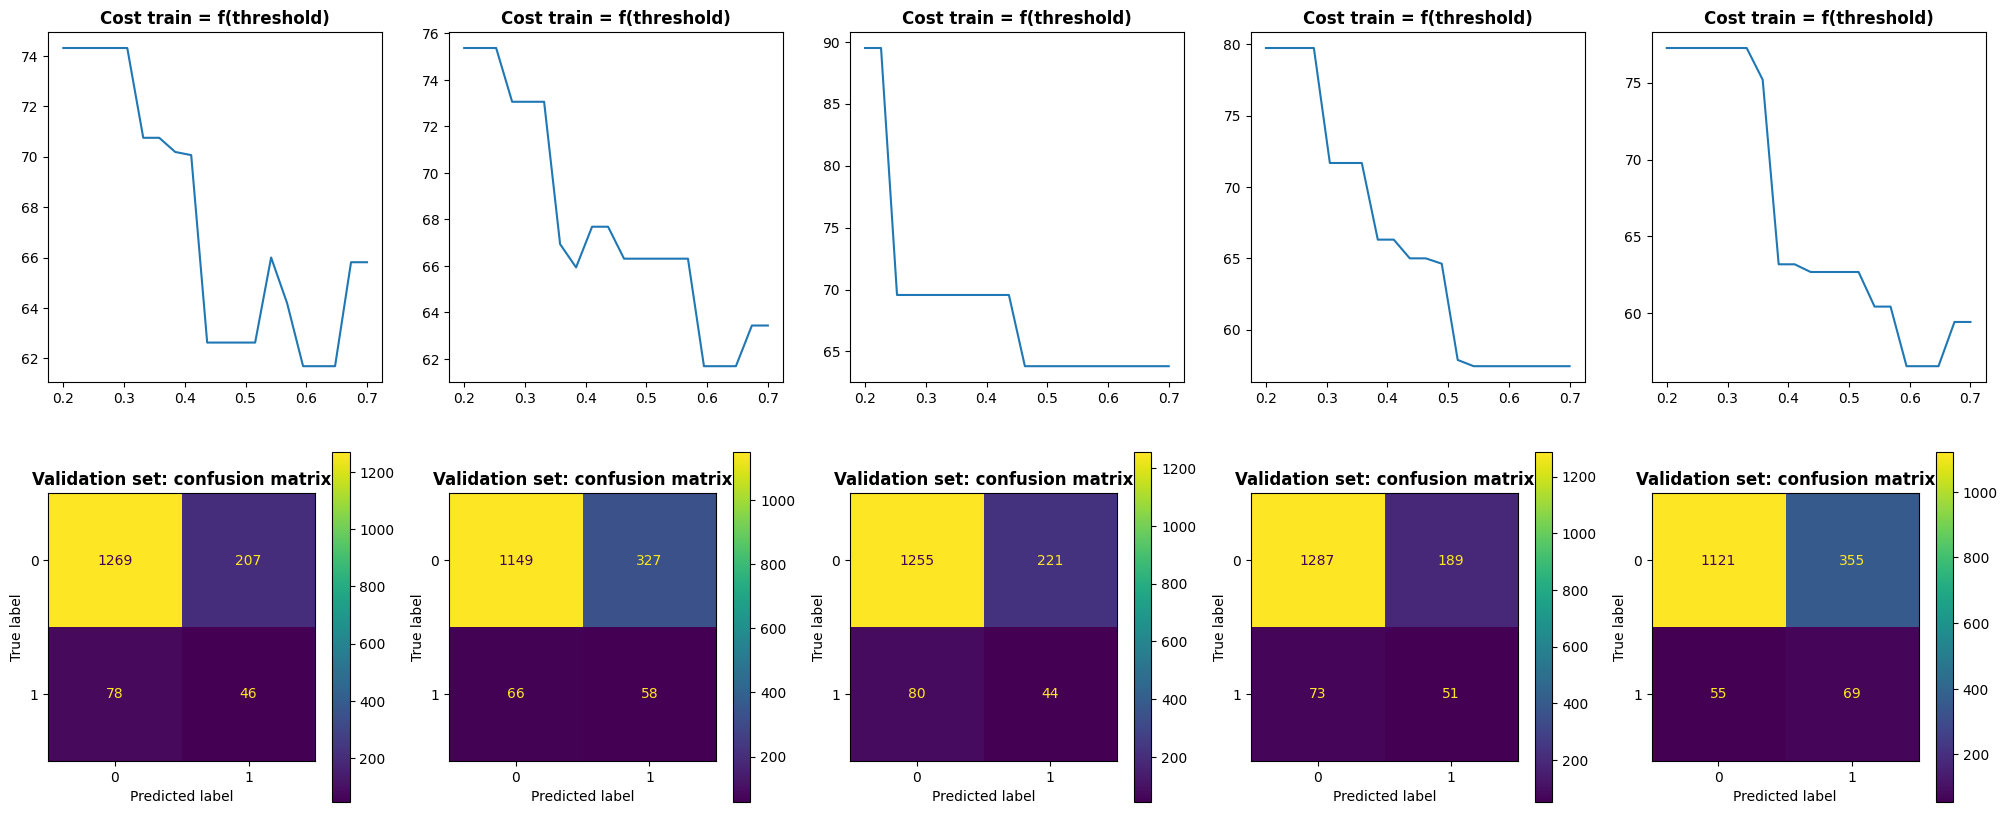

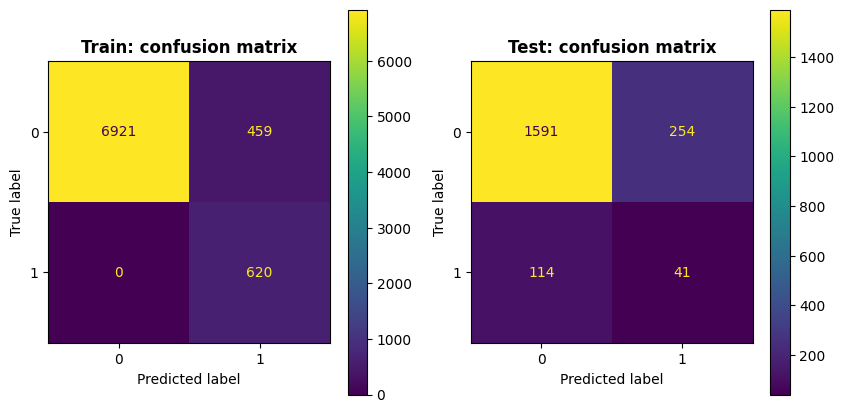

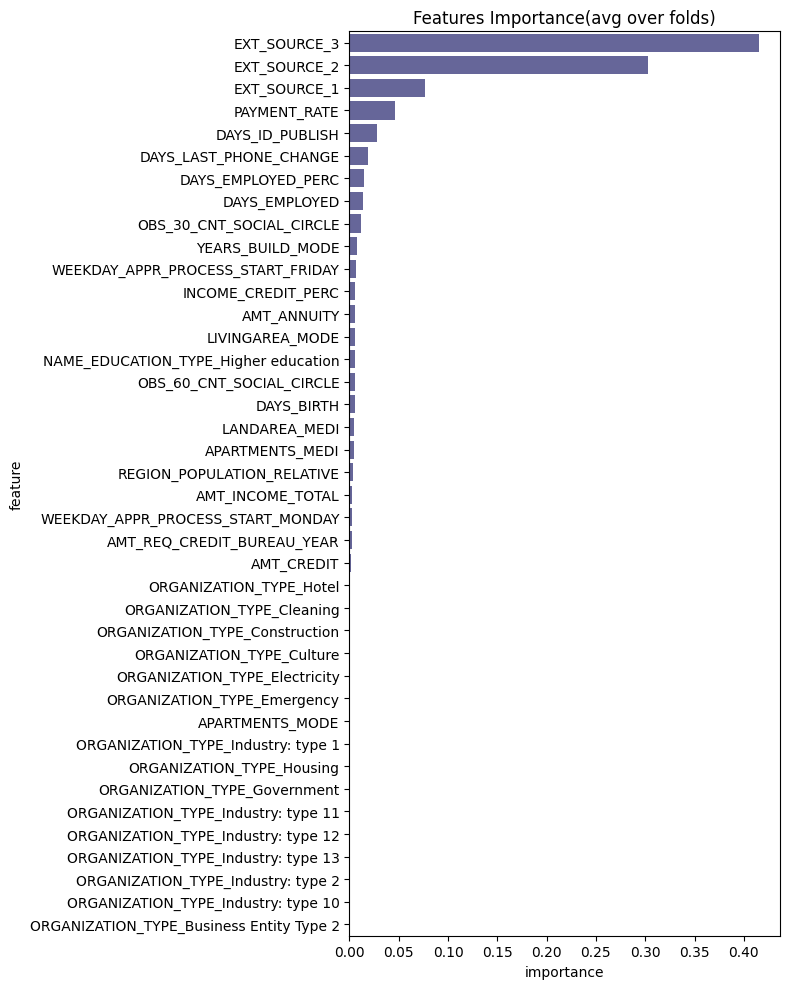

In [206]:
model_decision_tree_balanced(df_10000)

In [168]:
saved_Decision_Tree_model = joblib.load('Decision_Tree_model.joblib')

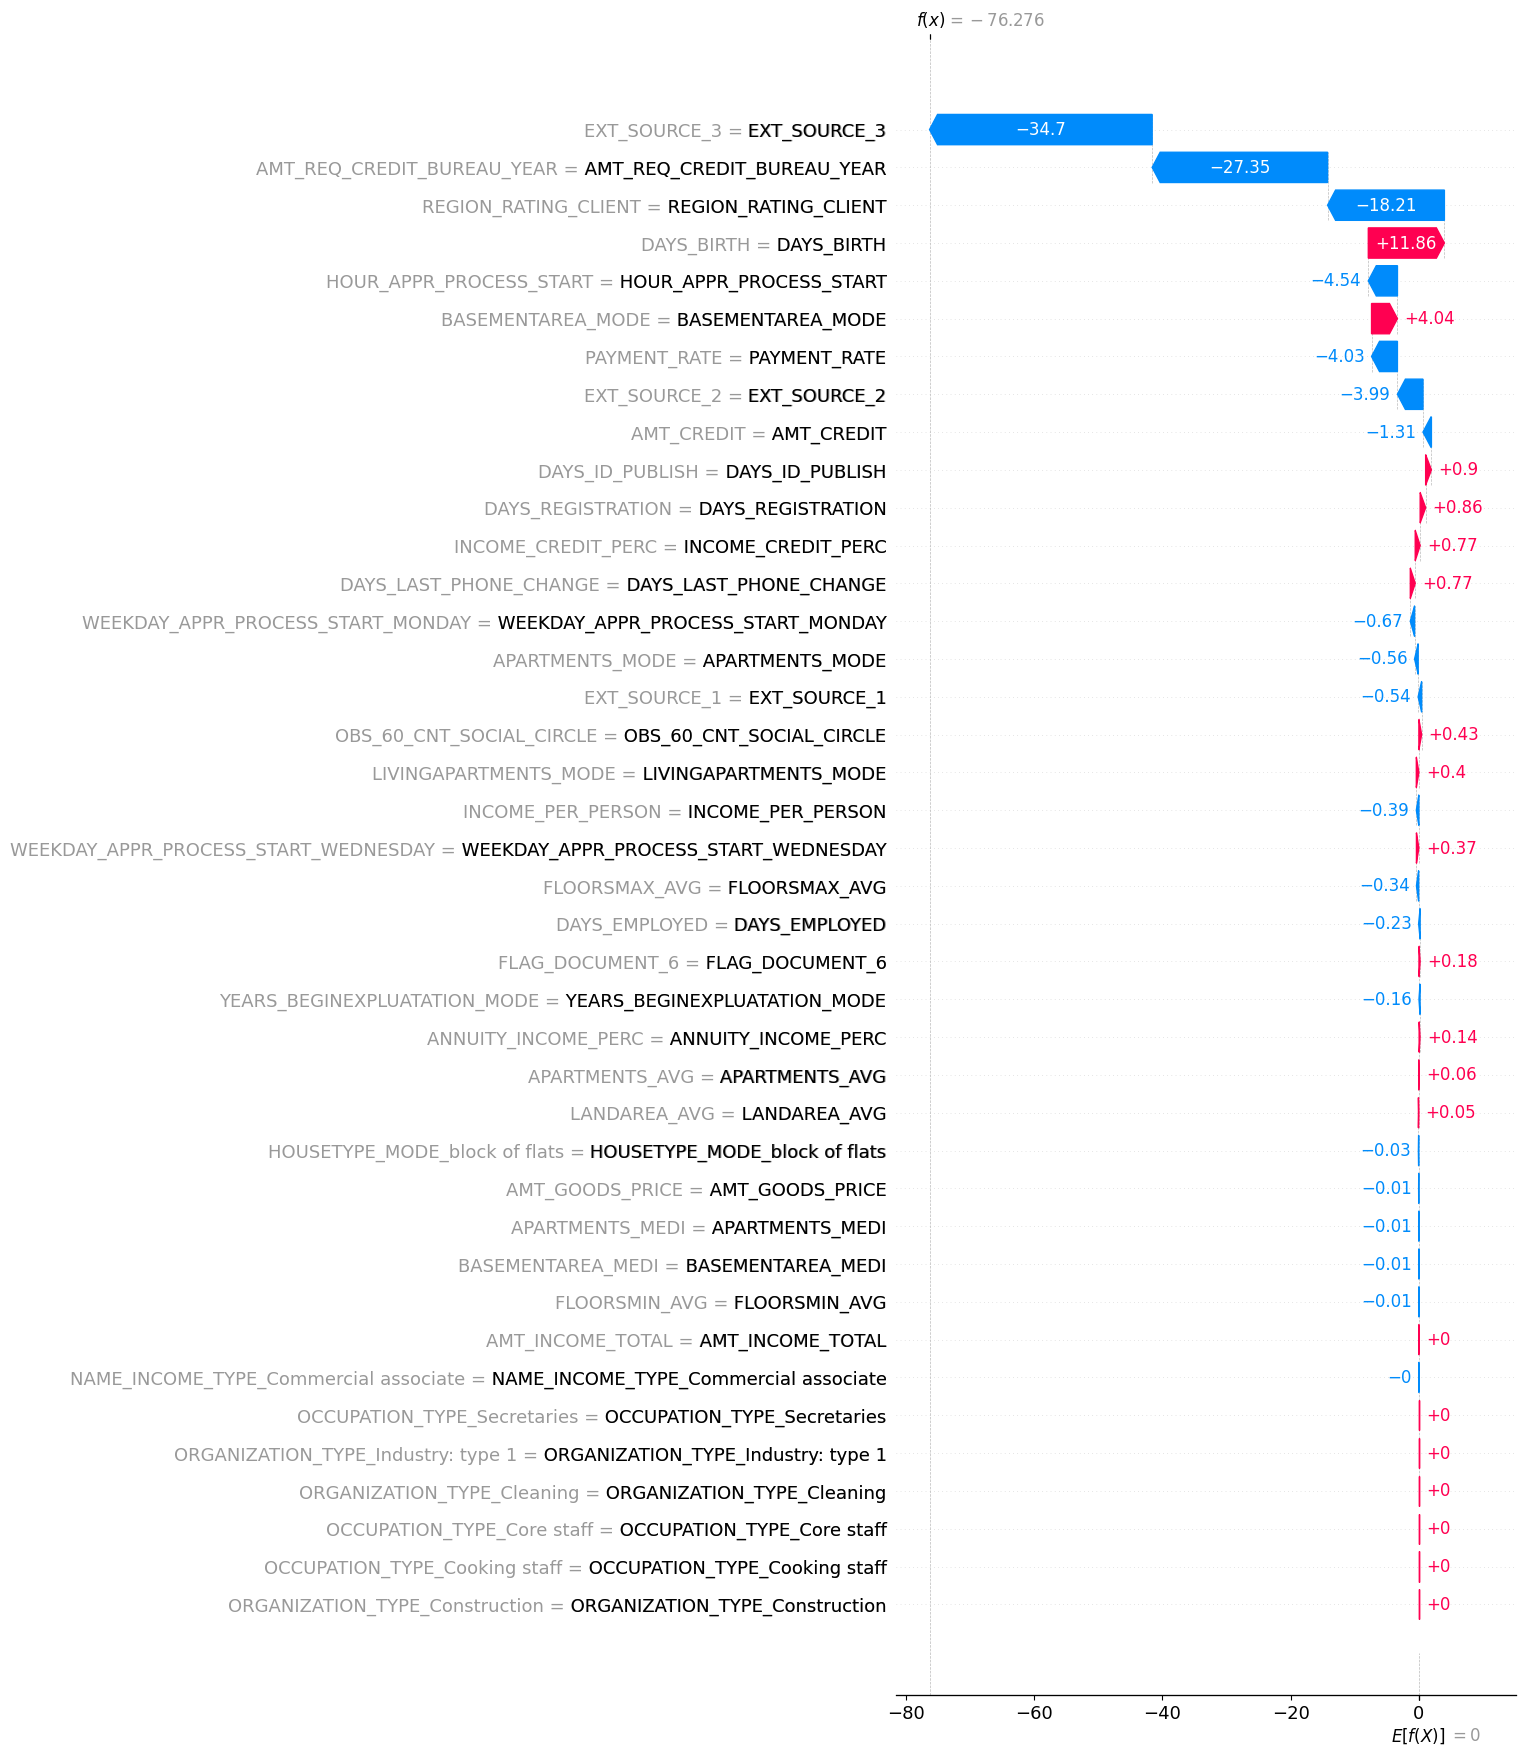

In [169]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.TreeExplainer(saved_Decision_Tree_model['model'], sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Decision_Tree_model['scl'].transform(X_test))
i=1
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Decision tree calibrated

In [198]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   

In [199]:
def model_decision_tree_calibrated(df, num_folds=10, stratified = True):
    with timer("Run Decision_Tree_calibrated"):
        Decision_Tree_calibrated(df, num_folds, stratified)

Threshold optimum: 0.13684210526315788
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.10789473684210527
Threshold optimum - Mean: 0.10789473684210527
           Validation      Train       Test
Accuracy     0.846250   0.837750   0.804000
Cost        55.875000  47.162500  55.150000
F1_score     0.297143   0.347082   0.279412
Precision    0.230088   0.252193   0.195373
Profit      36.375000  45.087500  37.100000
Recall       0.419355   0.556452   0.490323
roc_auc      0.691188   0.768457   0.714104
Run Decision_Tree_calibrated - done in 10s


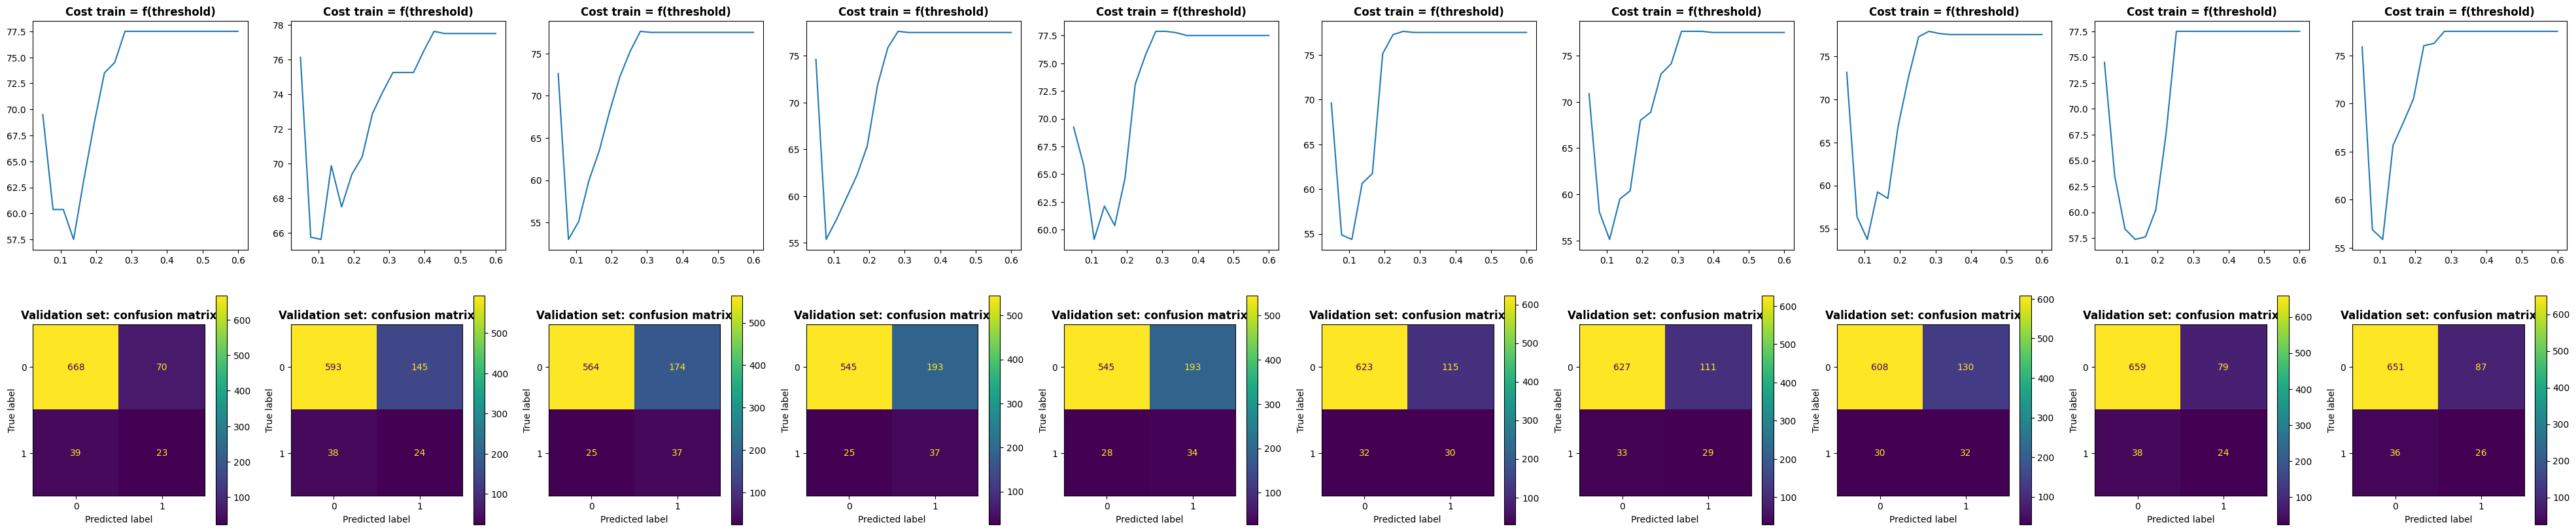

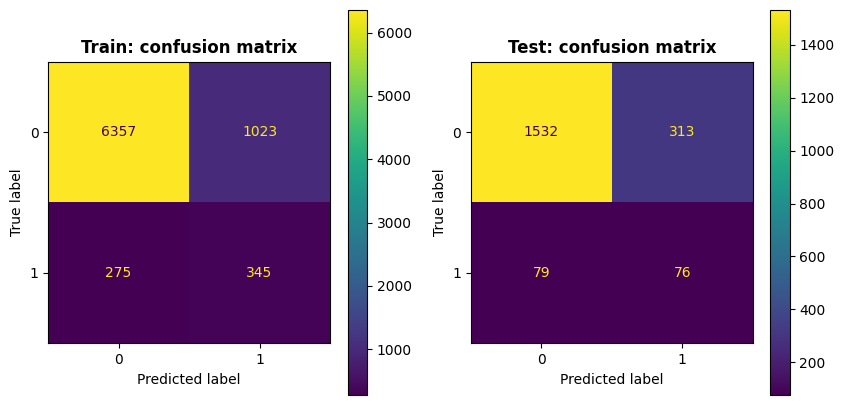

In [200]:
model_decision_tree_calibrated(df_10000)

In [683]:
saved_Decision_Tree_calibrated = joblib.load('Decision_Tree_calibrated_model.joblib')

In [716]:
saved_Decision_Tree_calibrated['model'].calibrated_classifiers_[0]

# Random forest

## Model

In [210]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Random_Forest(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.02, 0.2, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
   
    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'Random_Forest_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [211]:
def model5(df, num_folds=10, stratified = True):
    with timer("Run Random_Forest"):
        Random_Forest(df, num_folds, stratified)

Threshold optimum: 0.08631578947368422
Threshold optimum: 0.08631578947368422
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.08631578947368422
Threshold optimum: 0.09578947368421054
Threshold optimum: 0.09578947368421054
Threshold optimum: 0.08631578947368422
Threshold optimum - Mean: 0.09578947368421054
           Validation      Train       Test
Accuracy     0.697500   0.736250   0.712000
Cost        56.125000  49.887500  56.250000
F1_score     0.243750   0.280355   0.246073
Precision    0.151163   0.177768   0.154351
Profit      36.125000  42.362500  36.000000
Recall       0.629032   0.662903   0.606452
roc_auc      0.705197   0.777468   0.711468
Run Random_Forest - done in 13s


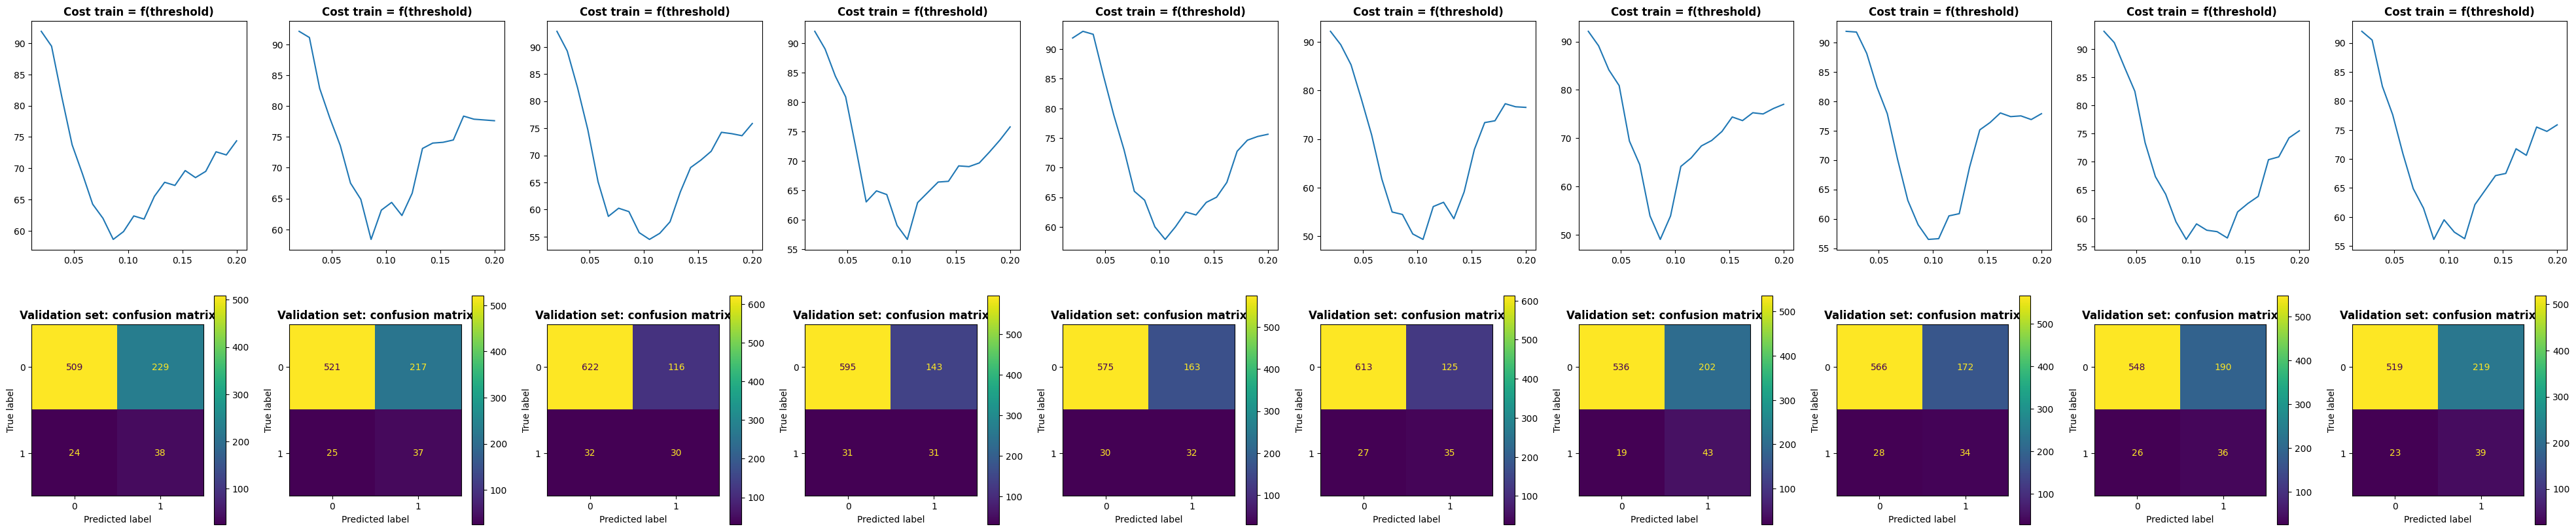

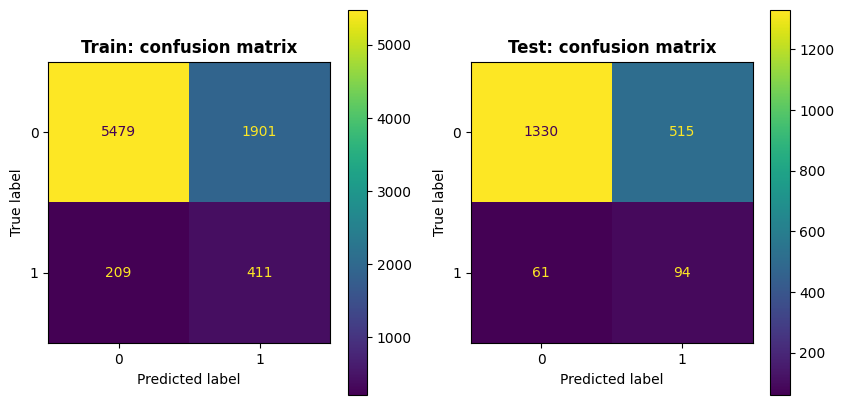

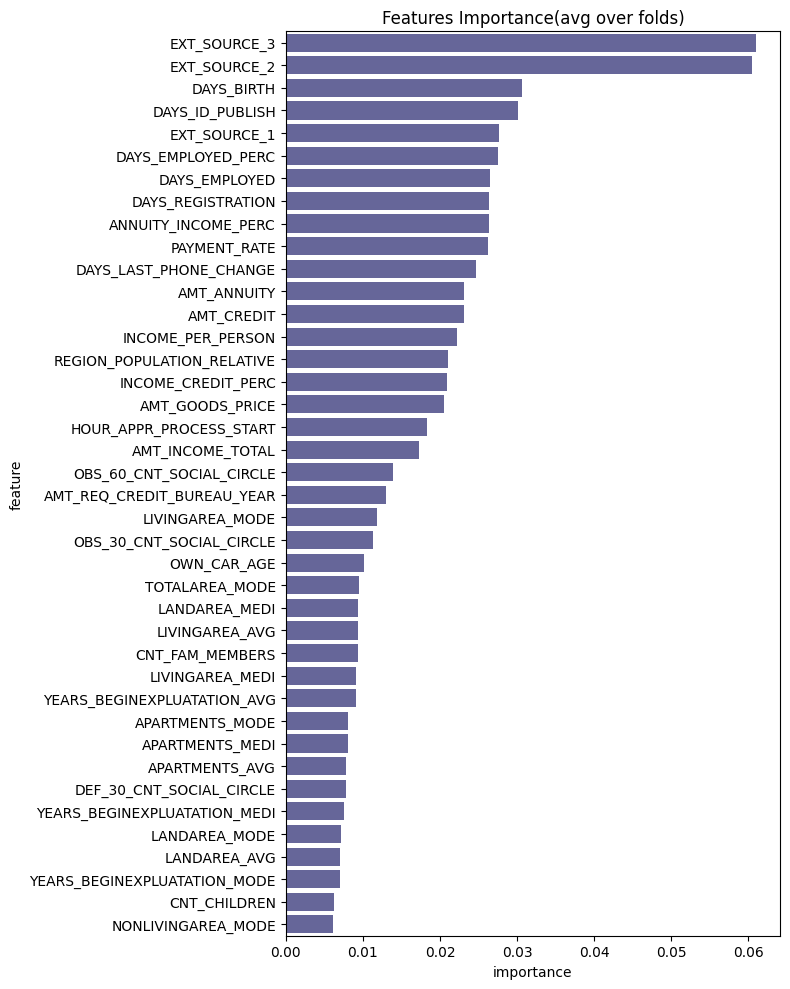

In [212]:
model5(df_10000)

In [725]:
saved_Random_Forest_model= joblib.load('Random_Forest_model.joblib')

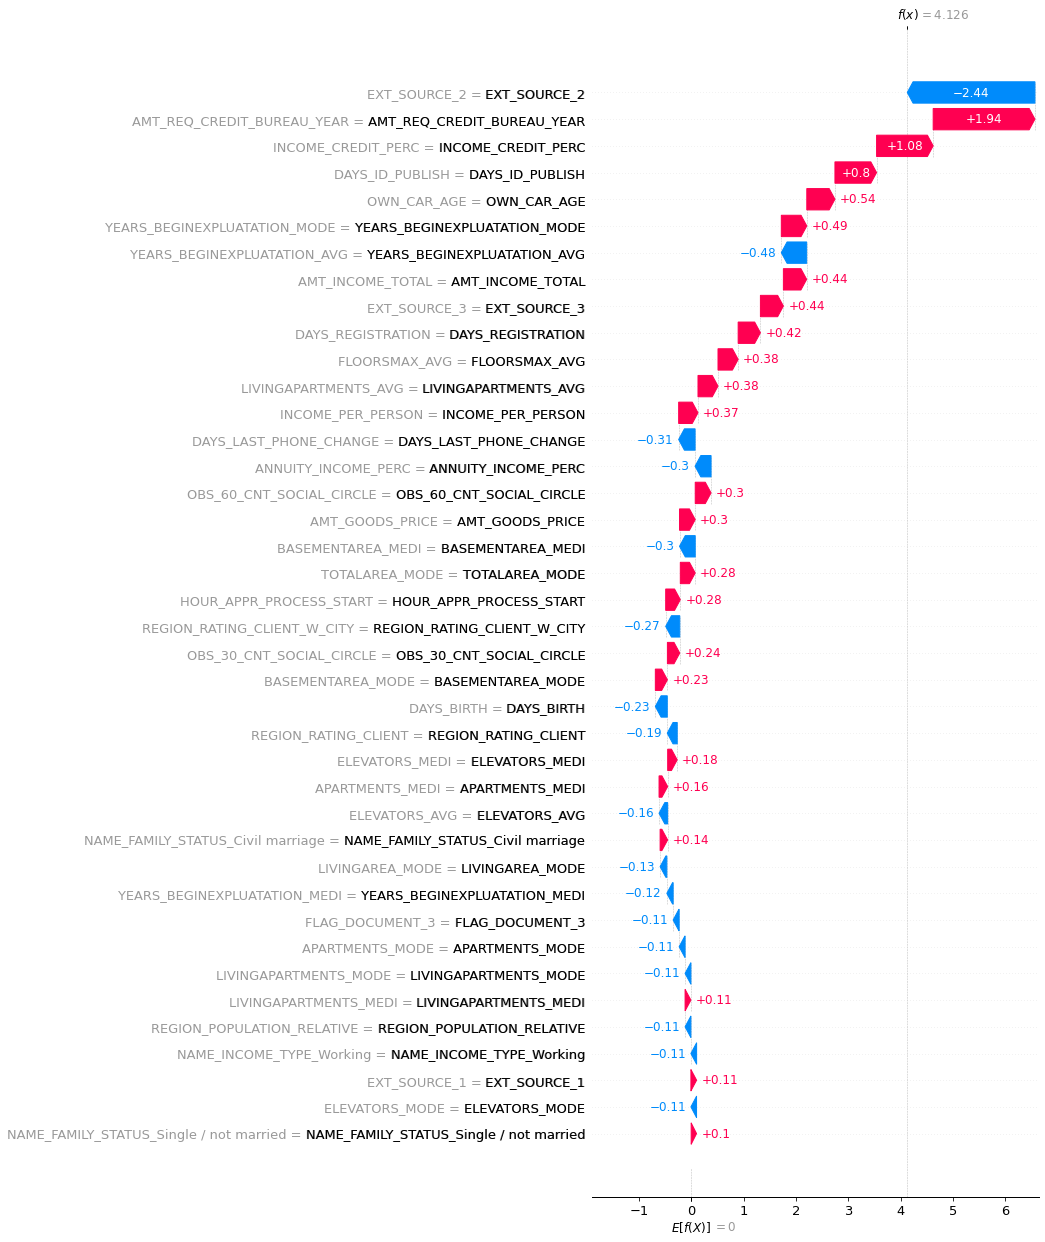

In [730]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.TreeExplainer(saved_Random_Forest_model['model'], sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Random_Forest_model['scl'].transform(X_test))
i=100
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Random_Forest_calibrated

In [213]:
def Random_Forest_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
    

In [214]:
def model_Random_Forest_calibrated(df, num_folds=10, stratified = True):
    with timer("Run Random_Forest"):
        Random_Forest_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09052631578947368
           Validation      Train       Test
Accuracy     0.688750   0.763500   0.725500
Cost        61.500000  47.387500  58.050000
F1_score     0.219436   0.301845   0.240664
Precision    0.136187   0.195694   0.153169
Profit      30.750000  44.862500  34.200000
Recall       0.564516   0.659677   0.561290
roc_auc      0.688019   0.798046   0.731933
Run Random_Forest - done in 24s


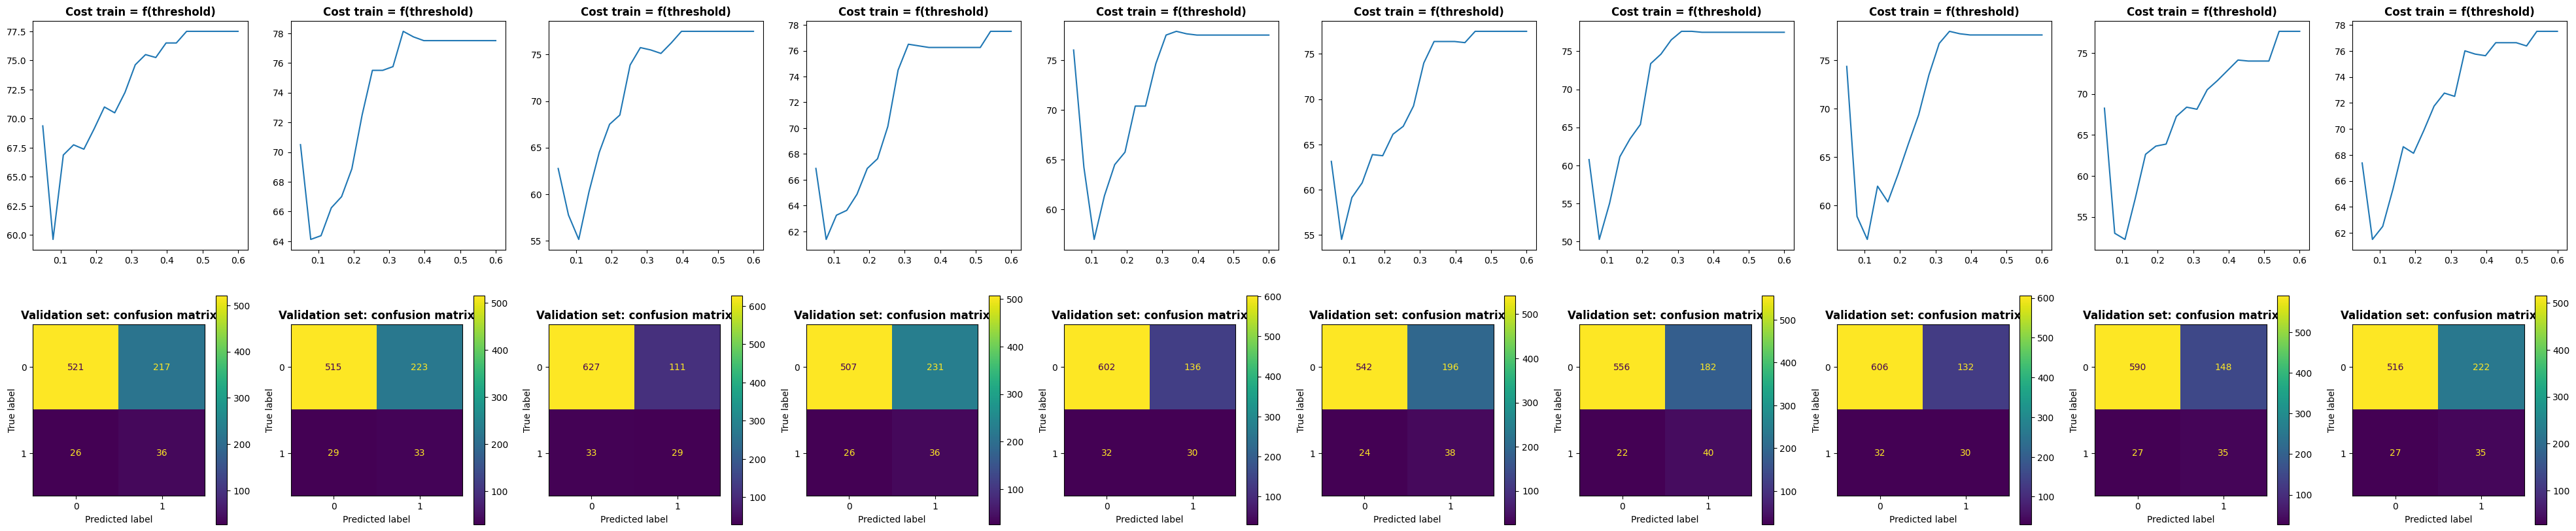

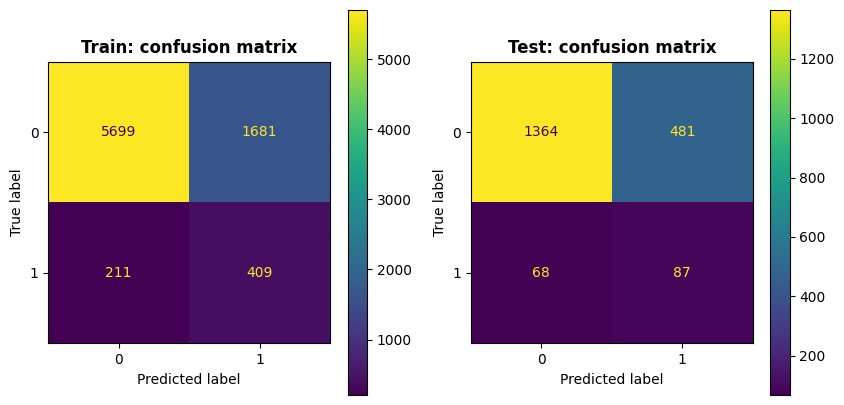

In [215]:
model_Random_Forest_calibrated(df_10000)

# KNN

In [863]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

def KNN(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]

        scl = MinMaxScaler()
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    scl = MinMaxScaler()
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    for calibr in pipe['model'].calibrated_classifiers_:
        fold_importance_df_calibr = pd.DataFrame()
        fold_importance_df_calibr["feature"] = features
        fold_importance_df_calibr["importance"] = permutation_importance(pipe, X_train, y_train, scoring='roc_auc').importances_mean
        fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
    fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    

In [866]:
def model6(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        KNN(df, num_folds, stratified)

Threshold optimum: 0.10789473684210527


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.10789473684210527


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.07894736842105263
Threshold optimum: 0.2526315789473684


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.12526315789473683


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


           Validation      Train       Test
Accuracy     0.906250   0.931250   0.940000
Cost        71.250000  68.750000  60.000000
F1_score     0.117647   0.098361   0.000000
Precision    0.200000   1.000000   0.000000
Profit      21.250000  24.000000  34.000000
Recall       0.083333   0.051724   0.000000
roc_auc      0.528153   0.809137   0.685505
Run Logistic regression balanced - done in 913s


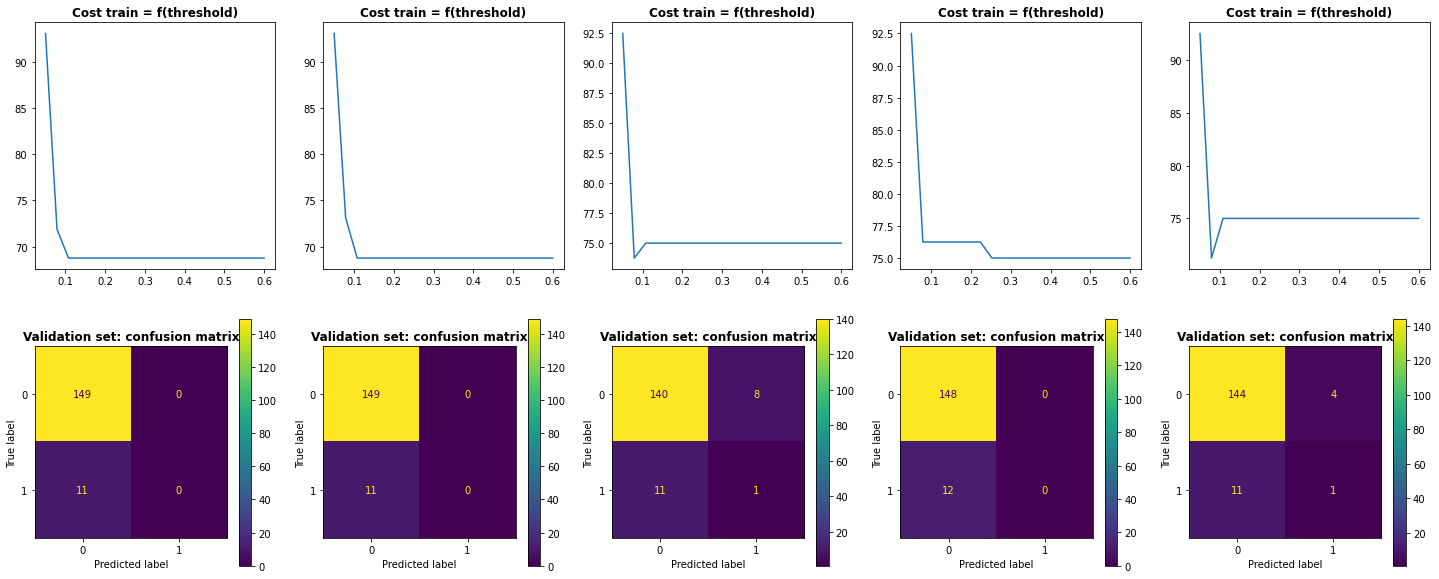

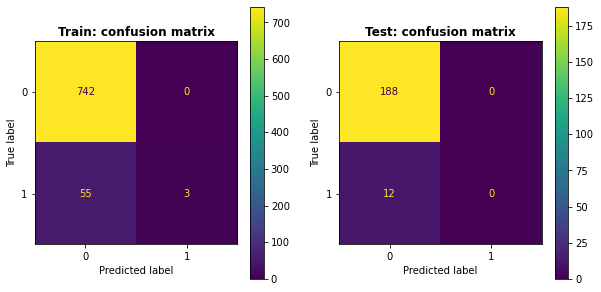

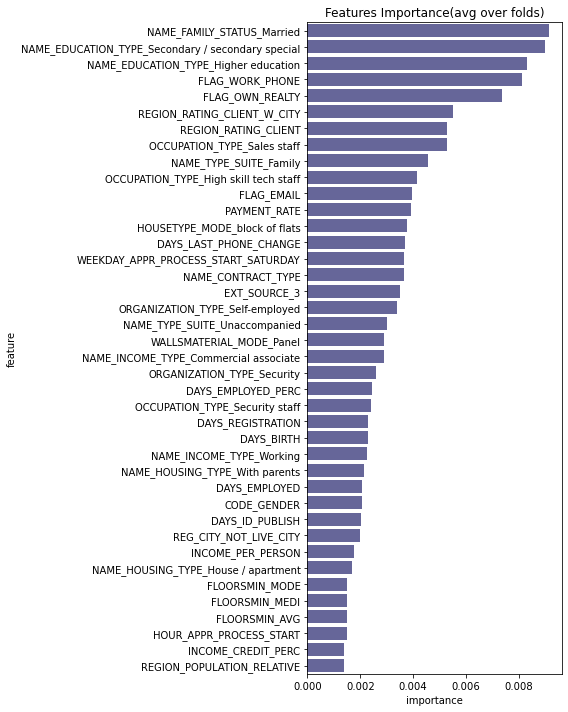

In [868]:
model6(data_transformed_1000)

In [872]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def KNN_smote(df, num_folds, stratified = False):
    
    from imblearn.pipeline import Pipeline
    
    X_train, X_test, y_train, y_test  = split_and_miss(df)
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = permutation_importance(pipe, train_x, train_y, scoring='roc_auc').importances_mean
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [873]:
def model6_bis(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        KNN_smote(df, num_folds, stratified)

Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.4
Threshold optimum: 0.4
Threshold optimum: 0.6052631578947368
Threshold optimum - Mean: 0.523157894736842
           Validation      Train       Test
Accuracy     0.593750   0.560000   0.445000
Cost        57.500000  44.000000  73.500000
F1_score     0.216867   0.247863   0.125984
Precision    0.126761   0.141463   0.069565
Profit      35.000000  48.750000  20.500000
Recall       0.750000   1.000000   0.666667
roc_auc      0.625282   0.960080   0.637190
Run Logistic regression balanced - done in 28s


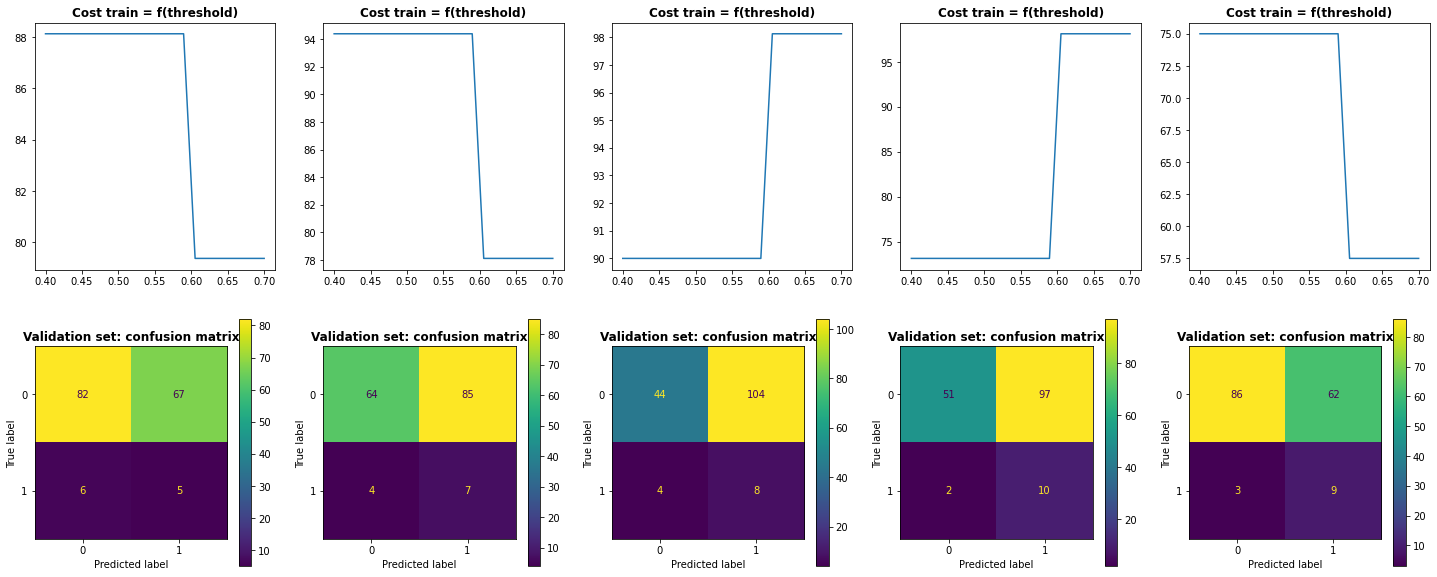

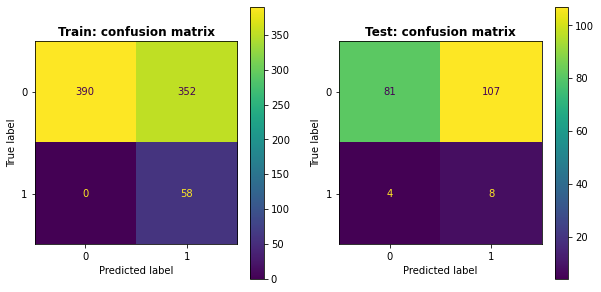

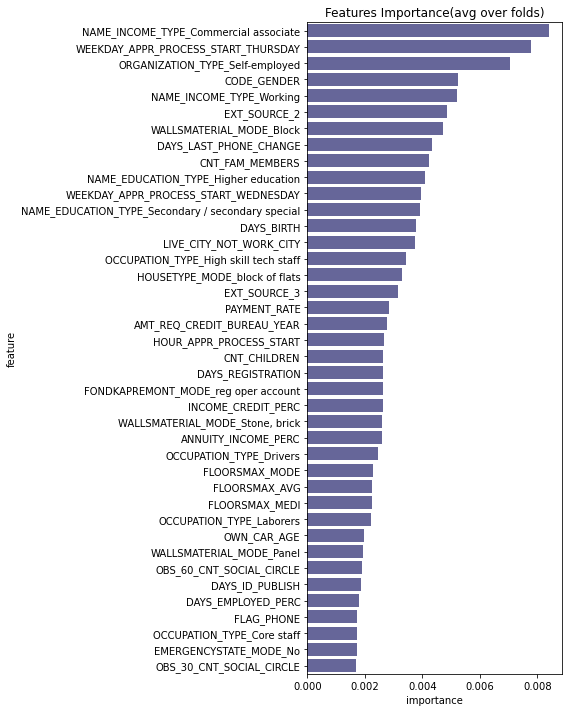

In [874]:
model6_bis(data_transformed_1000)

# Fin

In [839]:
X_train

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                      0            1             0                0   
1                      1            1             0                0   
2                      0            1             1                1   
3                      0            1             0                0   
4                      0            1             0                0   
...                  ...          ...           ...              ...   
7995                   0            0             1                0   
7996                   0            1             0                0   
7997                   0            1             0                1   
7998                   0            1             0                1   
7999                   0            1             1                0   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1          157500.0    485640.0      38263.5   
1                0          315000.0    382500.0      19125.0   
2                1          315000.0    700830.0      18486.0   
3                0           45000.0    254700.0      14751.0   
4                0          225000.0    463500.0      15079.5   
...            ...               ...         ...          ...   
7995             2          211500.0    277969.5      16087.5   
7996             0          247500.0    225000.0      22050.0   
7997             0           67500.0    276277.5      14593.5   
7998             0           87750.0    454500.0      14661.0   
7999             0          180000.0    273636.0      15835.5   

      AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            450000.0                    0.010006      -12956         -151.0   
1            382500.0                    0.019101      -16292        -5504.0   
2            585000.0                    0.002506      -19015        -3497.0   
3            225000.0                    0.009175      -23815        -1699.0   
4            463500.0                    0.030755      -18018        -3838.0   
...               ...                         ...         ...            ...   
7995         229500.0                    0.030755      -13673        -2079.0   
7996         225000.0                    0.032561      -23438        -2633.0   
7997         238500.0                    0.018029      -10487         -721.0   
7998         454500.0                    0.018850      -14441        -2286.0   
7999         247500.0                    0.022800      -18974        -2158.0   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0                -787.0            -4181          9.0           1   
1                -416.0            -2325          9.0           1   
2              -10981.0            -2280         14.0           1   
3                -188.0            -4386          9.0           1   
4               -7476.0            -1500          9.0           1   
...                 ...              ...          ...         ...   
7995             -418.0            -4501          1.0           1   
7996           -11084.0            -4047          9.0           1   
7997             -214.0             -647          9.0           1   
7998              -89.0            -1042          9.0           1   
7999            -7409.0            -2473          2.0           1   

      FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                  1                0                 1           0   
1                  1                0                 1           1   
2                  1                1                 1           1   
3                  0                0                 1           0   
4                  1                0                 1           0   
...              ...              ...               ...         ...   
7995               1                0                 1           0   
79